# Two Harmonic
This looks at how much information can be extracted about the seasonal cycle, restricting ourselves to a two harmonics.

In [1]:
import sys
import os

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list, numerical
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier_analytic, get_temp_fourier_numerical, get_temp_extrema_analytic,\
    get_temp_extrema_numerical
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from scipy import optimize, ndimage
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [177]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc', 
            'flux_lhe', 'flux_t', 'drag_q', 'q_surf', 'rho', 'p_atm', 'ps', 'q_surf', 'ucomp', 'vcomp', 'w_atm']
# Load dataset

# # DEFAULT experiment
# exp_dir = 'tau_sweep/aquaplanet/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}" for i in range(n_exp)]

# # Experiment with no-WISHE and no convection
# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}_no_conv" for i in range(n_exp)]

# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = ["k=1"]

# exp_dir = 'aquaplanet/latent_heat_temp_only/'
# exp_name = ['evap=0_1']
exp_dir = 'aquaplanet/latent_heat_temp_only/depth=20/'
exp_name = ['base']


# Get low level sigma level
namelist = isca_tools.load_namelist(exp_dir+exp_name[0])
p_surface_approx = namelist['spectral_dynamics_nml']['reference_sea_level_press']/100
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')
sigma_near_surf = sigma_levels_full[-1]

n_exp = len(exp_name)
lat_range = slice(30, 90)               # only consider NH and outside deep tropics, and ignore high latitudes as need 2nd harmonic there
use_time_start = 360*2
ds_base = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_name[i])
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_use = ds_use.sel(time=slice(use_time_start, np.inf)).sel(lat=lat_range)
    ds_use = ds_use.sel(pfull=np.inf, method='nearest')      # only keep lowest level
    # Compute variables required for flux breakdown
    ds_use['emission_factor'] = ds_use.lwdn_sfc/(Stefan_Boltzmann*ds_use.temp**4)
    ds_use['temp_diseqb'] = ds_use.t_surf - ds_use.temp
    ds_use['rh'] = ds_use.sphum / sphum_sat(ds_use.temp, ds_use.ps*sigma_near_surf)
    ds_use['lw_net'] = ds_use.lwup_sfc - ds_use.lwdn_sfc
    ds_base += [ds_use.load()]      # only keep after spin up
mixed_layer_depth = [isca_tools.load_namelist(exp_dir+exp_name[i])['mixed_layer_nml']['depth'] for i in range(n_exp)]

is_wishe=True
try:
    w_atm_const = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['w_atm_const']
    if w_atm_const > 0:
        is_wishe=False
        for i in range(n_exp):
            # Set wind to the constant value if it is set in namelist
            ds_base[i]['w_atm'] = ds_base[i]['w_atm']*0+w_atm_const
except KeyError:
    w_atm_const = np.nan

try: 
    rh_flux_q = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['rh_flux_q']
except KeyError:
    rh_flux_q = 0
try:
    evap_prefactor = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['land_evap_prefactor']
except KeyError:
    evap_prefactor = 1

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:52: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')


Removing height from var_keep


In [178]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
im_sz = 1.4     # larger makes images larger, keeping ar the same
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [179]:
def get_annual_zonal_mean(ds):
    ds_av = annual_mean(ds).mean(dim='lon')
    ds_av = ds_av.assign_coords(time=(ds_av.time - ds_av.time.min()).astype(int))
    return ds_av

In [180]:
ds = get_annual_zonal_mean(ds_base[0])
p_surface = float(ds.pfull)*100
if isinstance(w_atm_const, (int, float)):
    if w_atm_const == 0 or w_atm_const == np.nan:
        w_atm_const = ds.w_atm.mean(dim='time')

In [181]:
# Make every thing dependent on surface temperature (NOT NEAR-SURFACE) as equation easier to solve
# Link to near-surface with T_{s-a} term in latent flux etc
n_lat = ds.lat.size
n_time = ds.time.size
t_surf = ds.t_surf.to_numpy().transpose()
t_surf_anom = t_surf - np.mean(t_surf, axis=1)[:, np.newaxis]

## How many harmonics required?
Here we look fit a fourier expansion of a given number of harmonics directly to the temperature and shortwave radiation. It seems that there is a large reduction in error as we go from 1 to 2 harmonics, but not much more is gained by including more than 2 harmonics.

The surface energy budget is 
$$
C\frac{\partial T}{\partial t} = SW^{\downarrow} - (LW^{\uparrow} - LW^{\downarrow}) - LH^{\uparrow} - SH^{\uparrow}
= SW^{\downarrow} - \Gamma^{\downarrow}
$$

If we can approximate $\Gamma^{\downarrow} \approx \lambda_0 + \lambda T'(t)$ then an analytic solution for temperature anomaly $T'(t)$ is possible. Given this linear approximation, we look at the effect of increasing the number of harmonics. 

It seems that at all latitudes, there is not much difference between the 2 and 5 harmonic direct fit, so it makes sense to only go up to 2 harmonics.

For all latitudes, there seems to be a big difference between the linear fit and the direct fit; thus it makes sense to see if we can go beyond the linear fit to $\Gamma$.

In [182]:
sw_amp_coefs = {key: np.zeros((n_lat, 1+int(key.replace('_harmonic', '')))) for key in ['1_harmonic', '2_harmonic', '5_harmonic']}
sw_fourier_fit = {key: np.zeros((n_lat, n_time)) for key in ['1_harmonic', '2_harmonic', '5_harmonic']}
temp_anom_fourier_fit = {key: np.zeros((n_lat, n_time)) for key in ['1_harmonic', '2_harmonic', '5_harmonic']}
for key in sw_amp_coefs:
    for i in range(n_lat):
        sw_amp_coefs[key][i] = fourier.get_fourier_fit(ds.time, ds.swdn_sfc[:, i], int(key.replace('_harmonic', '')))[1]
        # Fit SW fourier with no phase
        sw_fourier_fit[key][i] = fourier.fourier_series(ds.time, sw_amp_coefs[key][i], np.zeros(int(key.replace('_harmonic', ''))))
        temp_anom_fourier_fit[key][i] = fourier.get_fourier_fit(ds.time, t_surf_anom[i], int(key.replace('_harmonic', '')))[0]
    temp_anom_fourier_fit[key] = temp_anom_fourier_fit[key] - np.mean(temp_anom_fourier_fit[key], axis=1)[:, np.newaxis]
# Record phase of maxima / minima relative to extrema times of 1st harmonic of SW radiation 
time_extrema_sw = {'min': int(ds.time[0]), 'max': int(ds.time[int(ds.time.size/2)])}
smooth_ndays_temp_extrema = 20            # smoothing to temp annual mean to find date of hottest day

time_extrema_temp = {key: {'simulated': np.zeros(n_lat)} for key in ['min', 'max']}
amp_extrema_temp = {key: {'simulated': np.zeros(n_lat)} for key in ['min', 'max']}
for key in time_extrema_temp['min']:
    for i in range(n_lat):
        # No smoothing for '1_harmonic' as already fit smooth fourier solution
        time_extrema_temp['min'][key][i], time_extrema_temp['max'][key][i], amp_extrema_temp['min'][key][i], amp_extrema_temp['max'][key][i] = \
            get_temp_extrema_numerical(ds.time, t_surf_anom[i], smooth_ndays_temp_extrema)

In [183]:
# General plotting info
plot_lat_approx = 90
plot_lat_ind = np.argmin(np.abs(ds.lat-plot_lat_approx).to_numpy())
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
ax_lims_time = [ds.time[0]-1, ds.time[-1]+1]
ax_lims_lat = [np.floor(ds.lat[0]), np.ceil(ds.lat[-1])]
color_approx = {'simulated': 'k', 'direct fit': 'k', 'linear': default_colors[0], 'square': default_colors[1], '1_harmonic': 'k',
                'lw': default_colors[3], 'lh': default_colors[1], 'sh': default_colors[2], 'linear_phase': default_colors[0], 
                'square_phase': default_colors[1], '6_order_phase': default_colors[3], 'square_phase_fourier': default_colors[1],
                '6_order_phase_fourier': default_colors[3], 'linear_phase_fourier': default_colors[0]}
color_extrema = {'max': default_colors[3], 'min': default_colors[0]}
linestyle_approx = {'simulated': '-', 'direct fit': ':', 'linear': ':', '1_harmonic': ':', 'linear_phase': '--', 'linear_phase_0': '-', 
                    'square': ':', 'square_phase': '--', '6_order_phase': '--', 'square_phase_fourier': '-', '6_order_phase_fourier': '-',
                    'linear_phase_fourier': '-'}
color_harmonic = {'1_harmonic': 'k', '2_harmonic': default_colors[1], '5_harmonic': default_colors[3]}
color_var = {'sum': 'k', 'w_atm': default_colors[2], 'drag_q': default_colors[1], 'rh': default_colors[0], 'temp_diseqb': default_colors[4], 
             'ps': default_colors[5], 'emission_factor': default_colors[0], 't_surf': default_colors[3]}
var_unit_labels = {'w_atm': '[ms$^{-1}$]', 'drag_q': None, 'rh': None, 'temp_diseqb': '[K]', 'ps': '[Pa]', 'emission_factor': None}

# Define error func to use
error_func_dict = {'max': lambda x, x_approx, norm=False, axis=1: np.max(np.abs(x - x_approx), axis=axis) / 
                                                                 (0.01*x.max(axis=axis)-0.01*x.min(axis=axis) if norm else 1), 
                   'median': lambda x, x_approx, norm=False, axis=1: np.median(np.abs(x - x_approx), axis=axis) / 
                                                                 (0.01*x.max(axis=axis)-0.01*x.min(axis=axis) if norm else 1), 
                   'mean': lambda x, x_approx, norm=False, axis=1: np.mean(np.abs(x - x_approx), axis=axis) / 
                                                                  (0.01*x.max(axis=axis)-0.01*x.min(axis=axis) if norm else 1)}
error_func_use = 'mean'
error_func = error_func_dict[error_func_use.lower()]

# Whether to show plots with smoothing of simulated values done or not. Theoretical curves always shown without smoothing
# Will also smooth simulated var but not approximated var before calculating error
# Fitting is always done with no smoothing performed first.
plot_smooth = True
if plot_smooth:
    smooth_func = lambda x, ax=-1: scipy.ndimage.convolve1d(x, np.ones(smooth_ndays_temp_extrema)/smooth_ndays_temp_extrema, mode='wrap', axis=ax)
else:
    smooth_func = lambda x, ax=0: x

resample = False        # whether to resample data so evenly spaced in x before finding polynomial coefficents.

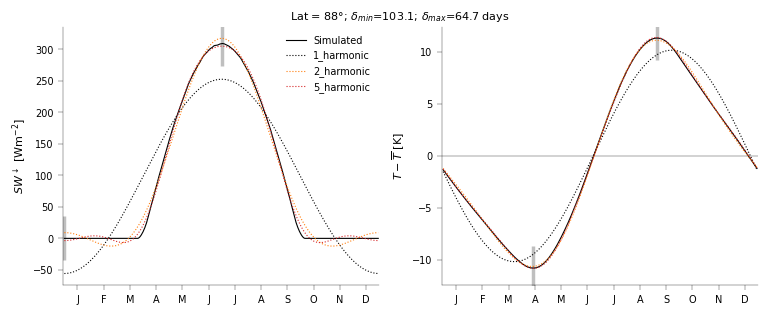

In [184]:
fig_sw_temp_sl, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
ax[0].plot(ds.time, ds.swdn_sfc[:, plot_lat_ind], color='k', label='Simulated')

ax[1].plot(ds.time, smooth_func(t_surf_anom[plot_lat_ind]), color='k', label='Simulated')
for key in time_extrema_sw:
    ax[0].scatter(time_extrema_sw[key], ds.swdn_sfc.sel(time=time_extrema_sw[key])[plot_lat_ind],
                       color='grey', marker='|', s=1000, lw=2.5, alpha=0.5)
    ax[1].scatter(time_extrema_temp[key]['simulated'][plot_lat_ind], (-1 if key=='min' else 1) * amp_extrema_temp[key]['simulated'][plot_lat_ind],
                       color='grey', marker='|', s=1000, lw=2.5, alpha=0.5)

ax[0].set_xlim(ax_lims_time)
ax[0].set_xticks(*month_ticks)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_ylim(-np.abs(ax[1].get_ylim()).max(), np.abs(ax[1].get_ylim()).max())
ax[0].set_ylabel('$SW^{\\downarrow}$ [Wm$^{-2}$]')
ax[1].set_ylabel('$T - \overline{T}$ [K]')
ax[0].legend()
fig_sw_temp_sl.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$; "
             f"$\delta_{'{min}'}$={round(time_extrema_temp['min']['simulated'][plot_lat_ind]-time_extrema_sw['min'], 1)}; "
             f"$\delta_{'{max}'}$={round(time_extrema_temp['max']['simulated'][plot_lat_ind]-time_extrema_sw['max'], 1)} days", fontsize=8, y=0.93)
for key in sw_fourier_fit:
    ax[0].plot(ds.time, sw_fourier_fit[key][plot_lat_ind], color=color_harmonic[key], linestyle=linestyle_approx['1_harmonic'], label=key)
    ax[1].plot(ds.time, temp_anom_fourier_fit[key][plot_lat_ind],
               color=color_harmonic[key], linestyle=linestyle_approx['1_harmonic'])
    ax[0].legend()
plt.show()

In [185]:
heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth[0])
n_approx_params = {'linear': 2, 'square': 3, '6_order': 7, 'square_phase_fourier': 6, 'linear_phase_fourier': 5}
for key in ['linear', 'square', '6_order']:
    n_approx_params[key+'_phase'] = n_approx_params[key]+1
gamma = {'simulated':np.asarray(ds.lwup_sfc - ds.lwdn_sfc + ds.flux_lhe + ds.flux_t).transpose(), 
         'linear': np.zeros((n_lat, n_time))}
gamma_params = {'linear': np.zeros((n_lat, n_approx_params['square_phase_fourier']))}      # lowest power is last
arg_ind = [4, 5]


temp_anom_linear_harmonics = {key: np.zeros((n_lat, n_time)) for key in sw_fourier_fit}
for i in range(n_lat):
    gamma_params['linear'][i, arg_ind] = numerical.polyfit_phase(t_surf_anom[i], gamma['simulated'][i], 1, include_phase=False, resample=resample)[1:]
    gamma['linear'][i] = np.polyval(gamma_params['linear'][i], t_surf_anom[i])
    for key in temp_anom_linear_harmonics:
        temp_anom_linear_harmonics[key][i] = get_temp_fourier_analytic(ds.time, ds.swdn_sfc.isel(lat=i), heat_capacity, gamma_params['linear'][i][4],
                                                                  n_harmonics_sw=int(key.replace('_harmonic', '')))[0]


Text(0.5, 0.02, 'Latitude [deg]')

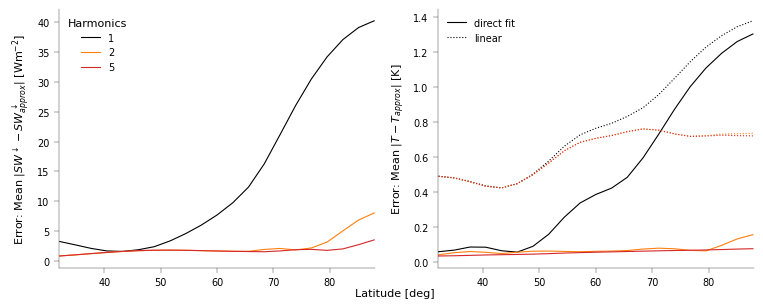

In [186]:
fig_error_sw, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=False)
for key in sw_fourier_fit:
    ax[0].plot(ds.lat, error_func(smooth_func(ds.swdn_sfc.transpose().to_numpy()), sw_fourier_fit[key], norm=False), color=color_harmonic[key],
               label=key.replace('_harmonic', ''))
    ax[1].plot(ds.lat, error_func(smooth_func(t_surf_anom), temp_anom_fourier_fit[key], norm=False), color=color_harmonic[key],
               label='direct fit' if '1' in key else None)
    ax[1].plot(ds.lat, error_func(smooth_func(t_surf_anom), temp_anom_linear_harmonics[key], norm=False), color=color_harmonic[key],
               label='linear' if '1' in key else None, linestyle=linestyle_approx['linear'])
# ax[1].plot(ds.lat, error_func(smooth_func(t_surf_anom), temp_anom_numerical['linear_phase'], norm=False), color=color_harmonic['2_harmonic'],
#            label='linear_phase', linestyle='--')
ax[0].legend(title='Harmonics')
ax[1].legend()
ax[0].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|SW^{\\downarrow} - SW^{\\downarrow}_{approx}|$ [Wm$^{-2}$]')
ax[1].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|T - T_{approx}|$ [K]')
ax[0].set_xlim(ax_lims_lat)
fig_error_sw.supxlabel('Latitude [deg]', fontsize=8, y=0.02)
# isca_tools.savefig(fig_error_sw, 'harmonic_error', save_if_exists=False)

## $\Gamma$ Empirical Fit

When looking at one harmonic, the following approximation, with three parameters that need to be found, seemed to provide a large improvement:

$\Gamma(t) \approx \lambda_0 + \lambda T'(t) + \frac{1}{2}\lambda_{phase}(T'(t-\mathcal{T}/4) - T'(t+\mathcal{T}/4))$

Below, we see that this does not help with 2 harmonics, so something else must be the issue.

With 2 harmonics, we can include powers of temperature in the surface energy budget, so we investigate the effect of including higher powers. It seems that there is a large improvement from including a squared term:

$\Gamma(t) \approx \lambda_0 + \lambda T'(t) + \frac{1}{2}\lambda_{phase}(T'(t-\mathcal{T}/4) - T'(t+\mathcal{T}/4)) + \lambda_{sq}T'(t)^2$

But not much more is gained by going up to the 6th power, so we assume the above approximation is the best we can do from just the temperature anomaly, $T'(t)$. To go beyond this, we compute the 2nd up to $N^{th}$ harmonic (where we seek an $N$ harmonic fourier solution for $T$) of the fourier series approximation of the residual after fitting 10 polynomials as well as a phase shift. This is to quantify the non-temperature dependent part of $\Gamma$, we exclude the 0th and 1st harmonic as they will be included in the polynomial and phase fitting stuff. With this, the final approximation for $\Gamma$ is:

$\lambda_0 + \frac{1}{2}\lambda_{phase}(T'(t-\mathcal{T}/4) - T'(t+\mathcal{T}/4)) + \lambda T'(t) + \lambda_{sq}T'(t)^2 + \sum_{n=2}^N (\Lambda_{n, cos}\cos(2n\pi t/\mathcal{T}) + \Lambda_{n, sin}\sin(2n\pi t/\mathcal{T}))$

With this final form of $\Gamma$, the error is pretty small, indicating this is pretty good.

#### Numerical Solution of Temperature
The error reduction in $\Gamma$ is also reflected in the numerical solution for the 2 harmonic Fourier expansion of temperature which satisfies the differential equation.

The numerical solution with the final form of $\Gamma$ is pretty close to the direct fit, although there does seem to be a systematic offset. But is definately good enough for our purposes.

In [187]:
key = 'simulated'
gamma_comp_params = {key: {} for key in ['lw', 'lh', 'sh']}
gamma_comp = {key: {} for key in ['lw', 'lh', 'sh']}
gamma_comp['lw'][key] = (ds.lwup_sfc-ds.lwdn_sfc).transpose().to_numpy()
gamma_comp['lh'][key] = (ds.flux_lhe).transpose().to_numpy()
gamma_comp['sh'][key] = (ds.flux_t).transpose().to_numpy()

for key in ['linear', 'linear_phase', 'linear_phase_fourier', 'square', 'square_phase', 'square_phase_fourier']:
    for key2 in gamma_comp:
        gamma_comp_params[key2][key] = np.zeros((n_lat, n_approx_params[key]))
        gamma_comp[key2][key] = np.zeros((n_lat, n_time))
        for i in range(n_lat):
            if 'fourier' in key:
                # Last 4 parameters are the normal polyfit_phase parameters
                gamma_comp_params[key2][key][i, 2:], param_fourier_amp_use, param_fourier_phase_use = \
                    numerical.polyfit_phase(t_surf_anom[i], gamma_comp[key2]['simulated'][i],
                                            n_approx_params[key.replace('_phase_fourier', '')] - 1, resample=resample,
                                            fourier_harmonics=np.asarray([2]))
                # first 2 parameters are fourier coefficients - convert to cos and sin coefficients so can add together
                gamma_comp_params[key2][key][i, :2] = fourier.coef_conversion(param_fourier_amp_use[2], param_fourier_phase_use[1])
                gamma_comp[key2][key][i] = numerical.polyval_phase(gamma_comp_params[key2][key][i, 2:], t_surf_anom[i],
                                                                   coefs_fourier_amp=param_fourier_amp_use, coefs_fourier_phase=param_fourier_phase_use)
            elif 'phase' in key:
                gamma_comp_params[key2][key][i] = numerical.polyfit_phase(t_surf_anom[i], gamma_comp[key2]['simulated'][i],
                                                                          n_approx_params[key.replace('_phase', '')] - 1, resample=resample)
                gamma_comp[key2][key][i] = numerical.polyval_phase(gamma_comp_params[key2][key][i], t_surf_anom[i])
            else:
                gamma_comp_params[key2][key][i] = numerical.polyfit_phase(t_surf_anom[i], gamma_comp[key2]['simulated'][i],
                                                                          n_approx_params[key]-1, include_phase=False, resample=resample)[1:]
                gamma_comp[key2][key][i] = np.polyval(gamma_comp_params[key2][key][i], t_surf_anom[i])

In [188]:
arg_ind = {'linear_phase': [2, 4, 5], 'linear_phase_fourier': [0, 1, 2, 4, 5], 'square': [3, 4, 5], 'square_phase': [2, 3, 4, 5],
           'square_phase_fourier': np.arange(6)}
for key in ['linear_phase', 'square', 'square_phase', 'square_phase_fourier', 'linear_phase_fourier']:
    gamma_params[key] = np.zeros((n_lat, n_approx_params['square_phase_fourier']))
    gamma[key] = np.zeros((n_lat, n_time))
    gamma_params[key][:, arg_ind[key]] = gamma_comp_params['lw'][key]+gamma_comp_params['lh'][key]+gamma_comp_params['sh'][key]
    for i in range(n_lat):
        param_fourier_amp_use, param_fourier_phase_use = fourier.coef_conversion(cos_coef=gamma_params[key][i, 0], sin_coef=gamma_params[key][i, 1])
        param_fourier_amp_use = np.asarray([0, 0, param_fourier_amp_use])
        param_fourier_phase_use = np.asarray([0, param_fourier_phase_use])
        gamma[key][i] = numerical.polyval_phase(gamma_params[key][i, 2:], t_surf_anom[i],
                                                coefs_fourier_amp=param_fourier_amp_use, coefs_fourier_phase=param_fourier_phase_use)
gamma_params['6_order_phase'] = np.zeros((n_lat, n_approx_params['6_order_phase']))
gamma['6_order_phase'] = np.zeros((n_lat, n_time))
gamma['6_order_phase_fourier'] = np.zeros((n_lat, n_time))
for i in range(n_lat):
    gamma_params['6_order_phase'][i] = numerical.polyfit_phase(t_surf_anom[i], gamma['simulated'][i], 6, resample=resample)
    gamma['6_order_phase'][i] = numerical.polyval_phase(gamma_params['6_order_phase'][i], t_surf_anom[i])
    param_poly_use, param_fourier_amp_use, param_fourier_phase_use = \
        numerical.polyfit_phase(t_surf_anom[i], gamma['simulated'][i], 6, resample=resample, fourier_harmonics=np.arange(2, 6+1))
    gamma['6_order_phase_fourier'][i] = numerical.polyval_phase(param_poly_use, t_surf_anom[i], coefs_fourier_amp=param_fourier_amp_use,
                                                                coefs_fourier_phase=param_fourier_phase_use)

Text(0.5, 0.93, 'Lat = $88\\degree$')

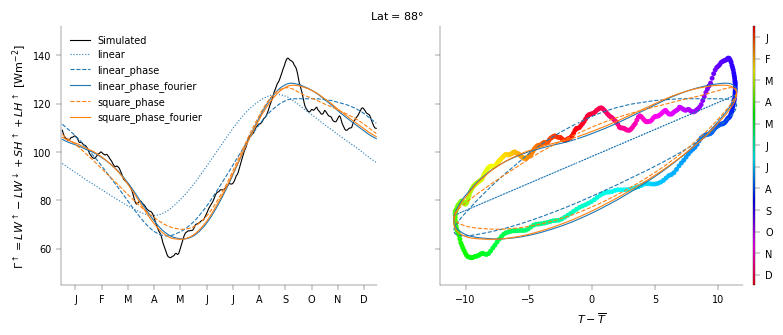

In [189]:
fig_sl_gamma, ax = plt.subplots(1,2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharey=True)
ax[0].plot(ds.time, smooth_func(gamma['simulated'][plot_lat_ind]), color='k', label='Simulated')
im = ax[1].scatter(smooth_func(t_surf_anom[plot_lat_ind]), smooth_func(gamma['simulated'][plot_lat_ind]), c=ds.time, cmap='hsv')
for key in ['linear', 'linear_phase', 'linear_phase_fourier', 'square_phase', 'square_phase_fourier']:
    ax[0].plot(ds.time, gamma[key][plot_lat_ind], color=color_approx[key], linestyle=linestyle_approx[key], label=key)
    ax[1].plot(t_surf_anom[plot_lat_ind], gamma[key][plot_lat_ind], color=color_approx[key], linestyle=linestyle_approx[key], label=key)

cbar = fig_sl_gamma.colorbar(im, ax=ax[1], aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
ax[0].set_ylabel('$\Gamma^{\\uparrow} = LW^{\\uparrow} - LW^{\\downarrow} + SH^{\\uparrow} + LH^{\\uparrow}$ [Wm$^{-2}$]')
ax[1].set_xlabel('$T - \overline{T}$')
ax[1].set_xlim(-np.ceil(np.abs(t_surf_anom[plot_lat_ind]).max()), np.ceil(np.abs(t_surf_anom[plot_lat_ind]).max()))
ax[1].set_ylim(np.floor(gamma['simulated'][plot_lat_ind].min()), np.ceil(gamma['simulated'][plot_lat_ind].max()))
ax[0].legend()
ax[0].set_xlim(-1, 360)
ax[0].set_xticks(*month_ticks)
fig_sl_gamma.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=8, y=0.93)
# isca_tools.savefig(fig_sl_gamma, f'gamma_fit_lat={ds.lat[plot_lat_ind]:.0f}', save_if_exists=False)

In [190]:
# Get approximate temperature for each level in hierarchy of gamma approximation
temp_anom_numerical = {key: np.zeros((n_lat, n_time)) for key in ['linear', 'linear_phase', 'square', 'square_phase', '6_order_phase',
                                                                  'square_phase_fourier', '6_order_phase_fourier',
                                                                  'linear_phase_fourier']}
for key in temp_anom_numerical:
    for i in range(n_lat):
        temp_anom_numerical[key][i] = get_temp_fourier_numerical(ds.time.to_numpy(), t_surf_anom[i], gamma['simulated'][i],
                                                                 ds.swdn_sfc.isel(lat=i).to_numpy(), heat_capacity, n_harmonics_sw=2,
                                                                 deg_gamma_fit=n_approx_params[key.replace('_phase', '').replace('_fourier', '')]-1,
                                                                 phase_gamma_fit='phase' in key, resample=resample,
                                                                 gamma_fourier_term='fourier' in key, include_sw_phase=False)[0]

Text(0.5, 0.01, 'Latitude [deg]')

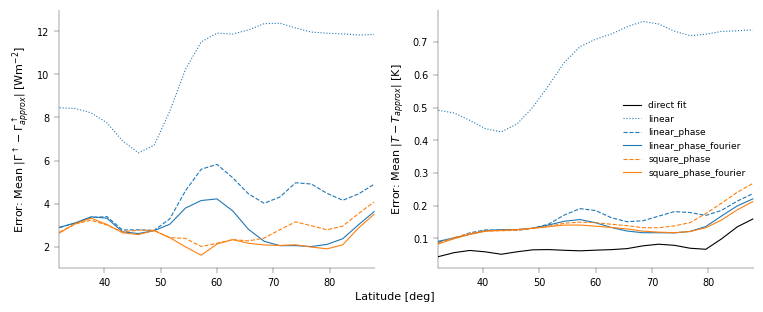

In [191]:
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
ax[1].plot(ds.lat, error_func(smooth_func(t_surf_anom), temp_anom_fourier_fit['2_harmonic'], norm=False), color=color_approx['direct fit'],
           label='direct fit')
# for key in ['linear', 'linear_phase', 'square', 'square_phase', '6_order_phase', 'square_phase_fourier', '6_order_phase_fourier']:
for key in ['linear', 'linear_phase', 'linear_phase_fourier', 'square_phase', 'square_phase_fourier']:
    ax[0].plot(ds.lat, error_func(smooth_func(gamma['simulated']), gamma[key]), color=color_approx[key],
               label=key, linestyle=linestyle_approx[key])
    ax[1].plot(ds.lat, error_func(smooth_func(t_surf_anom), temp_anom_numerical[key]), color=color_approx[key],
               label=key, linestyle=linestyle_approx[key])
    # if 'square' in key:
    #     ax[1].plot(ds.lat, error_func(smooth_func(t_surf_anom), temp_anom_analytic[key]), color=color_approx[key],
    #                label=key + ' (analytic)', linestyle=linestyle_approx[key], alpha=0.2)
ax[1].legend(fontsize=6.5)
ax[0].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|\Gamma^{\\uparrow} - \Gamma^{\\uparrow}_{approx}|$ [Wm$^{-2}$]')
ax[0].set_xlim(ax_lims_lat)
ax[0].set_ylim(1, 13)
# ax[1].set_ylim(0, 1.6)
ax[1].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|T - T_{approx}|$ [K]')
fig.supxlabel('Latitude [deg]', fontsize=8)
# isca_tools.savefig(fig, f'gamma_temp_error', save_if_exists=True, overwrite_file=True)

## Breakdown of $\Gamma$
Below we see the squared correction mainly comes from the latent and longwave heat flux. The sensible heat has a significant correction from the temperature independent Fourier term in $\Gamma$.

Including the Fourier term, the error is pretty small in each flux, but sensible heat is the largest across all latitudes.

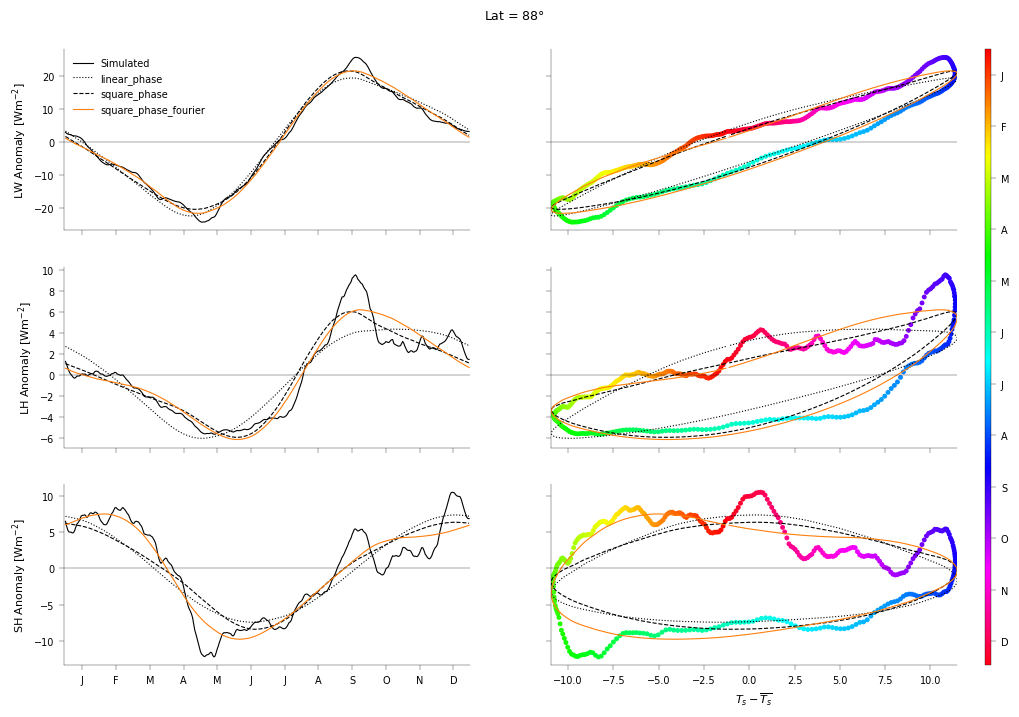

In [192]:
fig, ax = plt.subplots(3,2, figsize=(12, 8), sharey='row', sharex='col')
for i, key in enumerate(gamma_comp):
    ax[i, 0].plot(ds.time, smooth_func(gamma_comp[key]['simulated'][plot_lat_ind]-
                                       gamma_comp[key]['simulated'][plot_lat_ind].mean()), color='k', label='Simulated')
    im = ax[i, 1].scatter(smooth_func(t_surf_anom[plot_lat_ind]),
                          smooth_func(gamma_comp[key]['simulated'][plot_lat_ind]-gamma_comp[key]['simulated'][plot_lat_ind].mean()),
                          c=ds.time, cmap='hsv')
    for key2 in ['linear_phase', 'square_phase', 'square_phase_fourier']:
        ax[i, 0].plot(ds.time, gamma_comp[key][key2][plot_lat_ind]-gamma_comp[key][key2][plot_lat_ind].mean(),
                      color=color_approx[key2] if 'fourier' in key2 else 'k', linestyle=linestyle_approx[key2] if 'square' in key2 else ':', label=key2)
        ax[i, 1].plot(t_surf_anom[plot_lat_ind], gamma_comp[key][key2][plot_lat_ind]-gamma_comp[key][key2][plot_lat_ind].mean(),
                      color=color_approx[key2] if 'fourier' in key2 else 'k', linestyle=linestyle_approx[key2] if 'square' in key2 else ':')
    ax[i, 0].set_ylabel(key.upper() + ' Anomaly [Wm$^{-2}$]')
    # fit_param = optimize.curve_fit(square_func, t_surf_anom[no_conv_time_ind], var[no_conv_time_ind], [80, 3, 0])[0]
    # ax[i, 0].plot(ds.time, square_func(t_surf_anom, *fit_param), color='g', linestyle='--', label='Square fit (non convecting)')
    # ax[i, 1].plot(t_surf_anom, square_func(t_surf_anom, *fit_param), color='g', linestyle='--')
ax[0, 0].set_xlim(-1, 360)
ax[0, 1].set_xlim(t_surf_anom[plot_lat_ind].min(), t_surf_anom[plot_lat_ind].max())
ax[0, 0].legend()
ax[-1, 0].set_xticks(*month_ticks)
ax[-1, 1].set_xlabel('$T_s - \overline{T_s}$')
for ax_use in ax.flatten():
    ax_use.axhline(0, color='k', lw=ax_linewidth)
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);

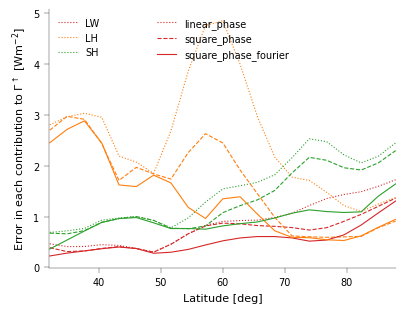

In [193]:
fig, ax = plt.subplots(1, 1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar))
lines = []
for key2 in ['linear_phase', 'square_phase', 'square_phase_fourier']:
    for key in gamma_comp:
        lines += [ax.plot(ds.lat, error_func(smooth_func(gamma_comp[key]['simulated']), gamma_comp[key][key2], norm=False), color=color_approx[key],
                   label=key.upper(), linestyle=':' if 'linear' in key2 else linestyle_approx[key2])[0]]
legend1 = ax.legend(handles=lines[:3], loc="upper left")
ax.add_artist(legend1)  # Add the first legend manually

# Second legend
ax.legend(handles=lines[::len(gamma_comp)], loc="upper center", labels=['linear_phase', 'square_phase', 'square_phase_fourier'])
ax.set_ylabel('Error in each contribution to $\Gamma^{\\uparrow}$ [Wm$^{-2}$]')
ax.set_xlim(ax_lims_lat)
ax.set_xlabel('Latitude [deg]');
# isca_tools.savefig(fig, f'gamma_cont_error', save_if_exists=False)

### $\Gamma$ Fitting Parameters
Below we see how each $\lambda$ parameter varies with latitude and the breakdown between fluxes. It is particularly apparent that the temperature independent Fourier contribution is largest at high latitudes.

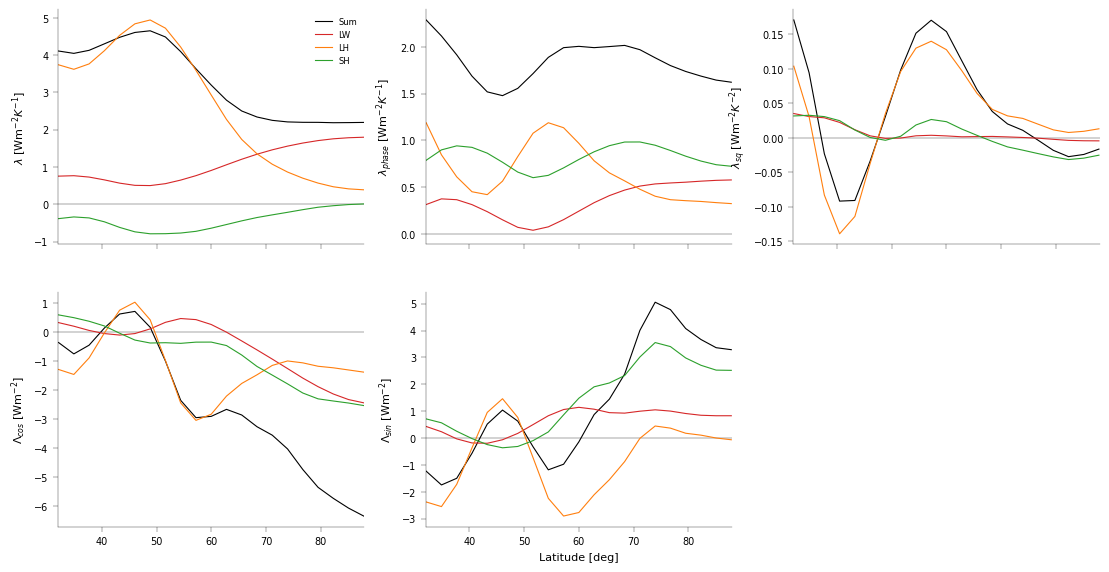

In [222]:
key = 'square_phase_fourier'
# arg_ind = np.append([n_approx_params[key]-2, 0], np.arange(1, n_approx_params[key]-2))
arg_ind = np.append([n_approx_params[key]-2-2*('fourier' in key), 0], np.arange(1, n_approx_params[key]-2-2*('fourier' in key)))
fig, ax = plt.subplots(2, 3, figsize=(im_sz*3*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True)
ax = ax.flatten()
for i in range(3):
    ax[i].axhline(0, color='k', lw=ax_linewidth)
    ax[i].plot(ds.lat, gamma_params[key][:, arg_ind[i]+2], color='k', label='Sum')
    for key2 in gamma_comp_params:
        ax[i].plot(ds.lat, gamma_comp_params[key2][key][:, arg_ind[i]+2*('fourier' in key)], color=color_approx[key2], label=key2.upper())
if 'fourier' in key:
    for i in range(2):
        ax[3+i].axhline(0, color='k', lw=ax_linewidth)
        ax[3+i].plot(ds.lat, gamma_params[key][:, i], color='k')
        for key2 in gamma_comp_params:
            ax[3+i].plot(ds.lat, gamma_comp_params[key2][key][:, i], color=color_approx[key2])
    ax[3].set_ylabel('$\Lambda_{cos}$ [Wm$^{-2}$]')
    ax[4].set_ylabel('$\Lambda_{sin}$ [Wm$^{-2}$]')
    ax[4].set_xlabel('Latitude [deg]')
    ax[5].remove()
else:
    ax[1].set_xlabel('Latitude [deg]')
    ax[5].remove()
    ax[4].remove()
    ax[3].remove()
ax[0].legend(frameon=True, framealpha=1, edgecolor='white', fontsize=6, loc='upper right')
ax[0].set_xlim(ax_lims_lat)
ax[0].set_ylabel('$\lambda$ [Wm$^{-2}K^{-1}$]')
ax[1].set_ylabel('$\lambda_{phase}$ [Wm$^{-2}K^{-1}$]')
ax[2].set_ylabel('$\lambda_{sq}$ [Wm$^{-2}K^{-2}$]')
plt.show()
# isca_tools.savefig(fig, f'gamma_cont_param', save_if_exists=False)

## Extrema
Next we look at the times and amplitudes of the extrema, as calculated from the numerical Fourier solutions for $T'(t)$.

We can see that the broad latitudinal trends are captured by the most simple linear approximation, indicating that the latitudinal variation in
insolation is mainly responsible for this.

The effect of $\lambda_{phase}$ is most apparent at low latitudes - reducing amplitude of extrema and shifting them to occur later in the year i.e. an increase in effective heat capacity.

The effect of $\lambda_{sq}$ is most apparent at high latitudes - increasing (reducing) amplitude and causing a shift later (earlier) in the
year of minima (maxima).

The effect of the temperature independent Fourier term is most apparent in the minima - it increases the amplitude and causes minima to occur
earlier in the year.

The square_phase_fourier fit is very similar to the direct fit, which is indicative of the best we can hope for with just two harmonics.
The main discrepancy to the direct fit is at high latitudes in the phase of the minima.

In [195]:
for key in ['direct fit', 'linear', 'linear_phase', 'square', 'square_phase', 'square_phase_fourier', 'linear_phase_fourier']:
    for key2 in time_extrema_temp:
        time_extrema_temp[key2][key] = np.zeros(n_lat)
        amp_extrema_temp[key2][key] = np.zeros(n_lat)
    for i in range(n_lat):
        # No smoothing for '1_harmonic' as already fit smooth fourier solution
        time_extrema_temp['min'][key][i], time_extrema_temp['max'][key][i], amp_extrema_temp['min'][key][i], amp_extrema_temp['max'][key][i] = \
            get_temp_extrema_numerical(ds.time, temp_anom_fourier_fit['2_harmonic'][i] if 'direct fit' in key else temp_anom_numerical[key][i])

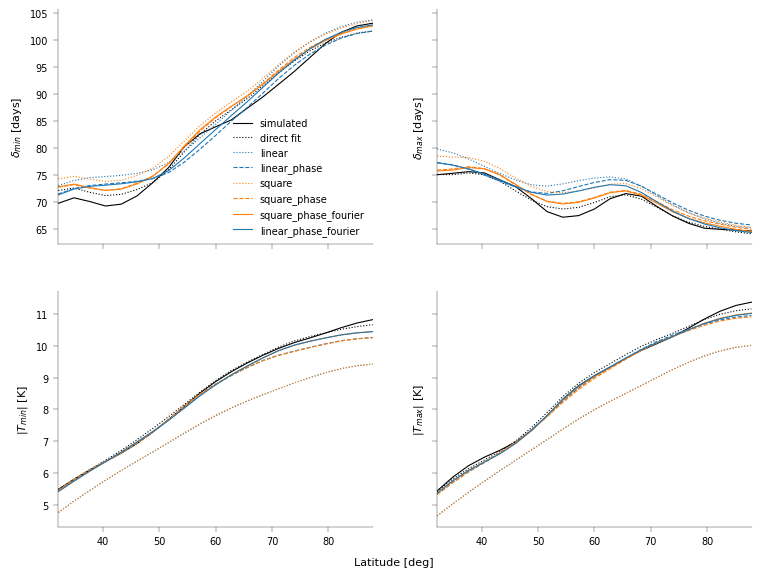

In [196]:
fig_extrema, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True, sharey='row')
for i, key in enumerate(time_extrema_temp):
    for key2 in ['simulated', 'direct fit', 'linear', 'linear_phase', 'square', 'square_phase', 'square_phase_fourier', 'linear_phase_fourier']:
    # for key2 in ['simulated', 'direct fit 1', 'direct fit', 'linear_phase', 'square_phase_fourier']:
        ax[0, i].plot(ds.lat, time_extrema_temp[key][key2] - time_extrema_sw[key], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2], label=key2)
        ax[1, i].plot(ds.lat, amp_extrema_temp[key][key2], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2])
    ax[0, i].set_ylabel(f"$\delta_{'{'+key+'}'}$ [days]")
    ax[1, i].set_ylabel(f"$|T_{'{'+key+'}'}|$ [K]")
ax[0, 0].set_xlim(ax_lims_lat)
ax[0, 0].legend()
fig_extrema.supxlabel('Latitude [deg]', fontsize=8, y=0.05);
# isca_tools.savefig(fig_extrema, f'extrema')

## Physical Interpretation of $\lambda$ and $\lambda_{phase}$
Now we try to get an idea of what sets the magnitude and latitudinal trend in $\lambda$ and $\lambda_{phase}$. We consider each flux contribution to $\lambda$ and $\lambda_{phase}$ in turn.
### Latent Heat

The [equation](https://github.com/jduffield65/Isca/blob/b9249275469583c1723f12ac62333067f9460fea/isca_source/src/coupler/surface_flux.F90#L598) used for latent heat flux by Isca is: $LH = f_{evap}L_v C_q\rho |v|(q^*(T_s, p_s) - q_{a})$

where $f_{evap}=0.1$ is the evaporative prefactor for this experiment.

So given that $q_a = r_aq^*(T_a, p_a)$; $\rho = p_a/RT_a$ where $T_a = T_s - T_{diseqb}$ and $p_a = \sigma_ap_s$, latent heat is only a function of 6 variables:

* Surface temperature, $T_s$
* Disequilibrium temperature, $T_{diseqb}$
* Relative humidity, $r_a$
* Drag coefficient $C_t$
* Wind speed, $|v|$
* Surface pressure $p_s$.

It is clear that the non-linear combinations are very important in this at high latitudes.

In [197]:
def get_latent_heat(temp_surf, temp_diseqb, rh, wind_speed, drag_coef, p_surf, sigma=sigma_near_surf, evap_prefactor=evap_prefactor):
    temp_a = temp_surf - temp_diseqb
    p_a = p_surf*sigma
    rho = get_density(temp_a, p_a)
    sphum_a = rh * sphum_sat(temp_a, p_a)
    return evap_prefactor * L_v * drag_coef * rho * wind_speed * (sphum_sat(temp_surf, p_surf) - sphum_a)

In [198]:
ds_mean = ds.mean(dim='time')
lh_manual = {'all_cont': get_annual_zonal_mean(get_latent_heat(ds_base[0].t_surf, ds_base[0].temp_diseqb, ds_base[0].rh,
                                                               ds_base[0].w_atm, ds_base[0].drag_q, ds_base[0].ps)),
             'all_cont_av_first': get_latent_heat(ds.t_surf, ds.temp_diseqb, ds.rh, ds.w_atm, ds.drag_q, ds.ps),
             'mean': get_latent_heat(ds_mean.t_surf, ds_mean.temp_diseqb, ds_mean.rh, ds_mean.w_atm,
                                       ds_mean.drag_q, ds_mean.ps)}

alpha_s = clausius_clapeyron_factor(ds_mean.t_surf, ds_mean.ps)
q_sat_s = sphum_sat(ds_mean.t_surf, ds_mean.ps)
alpha_a = clausius_clapeyron_factor(ds_mean.temp, sigma_near_surf*ds_mean.ps)
q_sat_a = sphum_sat(ds_mean.temp, sigma_near_surf*ds_mean.ps)
ds_mean['rho_calc'] = get_density(ds_mean.temp, sigma_near_surf*ds_mean.ps)
lh_prefactor = evap_prefactor*L_v*ds_mean.drag_q*ds_mean.w_atm*ds_mean.rho_calc

lh_taylor = {'t_surf': -lh_manual['mean']/ds_mean['temp'] + lh_prefactor*(alpha_s*q_sat_s-ds_mean.rh*alpha_a*q_sat_a),
             'temp_diseqb': lh_manual['mean']/ds_mean['temp'] + lh_prefactor*ds_mean.rh*alpha_a*q_sat_a,
             'rh': -lh_prefactor*q_sat_a}
for key in ['w_atm', 'drag_q', 'ps']:
    lh_taylor[key] = lh_manual['mean']/ds_mean[key]
lh_taylor['sum'] = 0
for key in lh_taylor:
    if key=='sum':
        continue
    lh_taylor['sum'] += (lh_taylor[key]*(ds[key]-ds_mean[key]))
lh_taylor['sum'] = lh_taylor['sum'] + lh_manual['mean']
lh_taylor['t_surf_square'] = -lh_taylor['t_surf']/ds_mean.temp + lh_manual['mean']/ds_mean.temp**2+lh_prefactor*(
    alpha_s*q_sat_s/ds_mean.t_surf * (alpha_s*ds_mean.t_surf-2) - ds_mean.rh*alpha_a*q_sat_a/ds_mean.temp * (alpha_a*ds_mean.temp-2))
lh_taylor['t_surf_cube'] = -lh_taylor['t_surf_square']/ds_mean.temp + 2*lh_taylor['t_surf']/ds_mean.temp**2 - 2*lh_manual['mean']/ds_mean.temp**3 + \
                           lh_prefactor*(alpha_s*q_sat_s/ds_mean.t_surf**2 * (alpha_s**2*ds_mean.t_surf**2 - 6*alpha_s*ds_mean.t_surf + 6) -
                                         ds_mean.rh*alpha_a*q_sat_a/ds_mean.temp**2 * (alpha_a**2*ds_mean.temp**2 - 6*alpha_a*ds_mean.temp + 6))
lh_taylor['t_surf_square']  = lh_taylor['t_surf_square']*0.5
lh_taylor['t_surf_cube'] = lh_taylor['t_surf_cube']/6
lh_taylor['t_surf_w_atm'] = lh_taylor['t_surf']/ds_mean.w_atm
lh_taylor['t_surf_drag_q'] = lh_taylor['t_surf']/ds_mean.drag_q
lh_taylor['t_surf_rh'] = -lh_prefactor * alpha_a*q_sat_a
lh_taylor['t_surf_square_rh'] = -lh_prefactor * alpha_a*q_sat_a/ds_mean.temp * (alpha_a*ds_mean.temp-2)
lh_taylor['t_surf_square_rh'] = lh_taylor['t_surf_square_rh'] * 0.5
lh_taylor['t_surf_cube_rh'] = -lh_prefactor * alpha_a*q_sat_a/ds_mean.temp**2 * (alpha_a**2*ds_mean.temp**2 - 6*alpha_a*ds_mean.temp + 6)
lh_taylor['t_surf_cube_rh'] = lh_taylor['t_surf_cube_rh']/6
lh_taylor['t_surf_temp_diseqb'] = lh_taylor['t_surf']/ds_mean.temp - lh_manual['mean']/ds_mean.temp**2 + lh_prefactor * (
    ds_mean.rh*alpha_a*q_sat_a/ds_mean.temp * (alpha_a*ds_mean.temp-2))
lh_taylor['w_atm_drag_q'] = lh_taylor['w_atm']/ds_mean.drag_q
lh_taylor['t_surf_square_w_atm'] = lh_taylor['t_surf_square'] / ds_mean.w_atm
# lh_taylor['t_surf_square_drag_q'] = lh_taylor['t_surf_square'] / ds_mean.drag_q


lh_taylor['sum'] += lh_taylor['t_surf_square'] * (ds['t_surf']-ds_mean['t_surf'])**2 + lh_taylor['t_surf_cube']*(ds['t_surf']-ds_mean['t_surf'])**3 + \
    lh_taylor['t_surf_rh']*(ds['t_surf']-ds_mean['t_surf'])*(ds['rh']-ds_mean['rh']) + \
                    lh_taylor['t_surf_square_rh']*(ds['t_surf']-ds_mean['t_surf'])**2*(ds['rh']-ds_mean['rh']) + \
    lh_taylor['t_surf_cube_rh']*(ds['t_surf']-ds_mean['t_surf'])**3*(ds['rh']-ds_mean['rh']) + \
    lh_taylor['t_surf_temp_diseqb']*(ds['t_surf']-ds_mean['t_surf'])*(ds['temp_diseqb']-ds_mean['temp_diseqb']) + \
    lh_taylor['t_surf_w_atm']*(ds['t_surf']-ds_mean['t_surf'])*(ds['w_atm']-ds_mean['w_atm']) + \
    lh_taylor['t_surf_drag_q']*(ds['t_surf']-ds_mean['t_surf'])*(ds['drag_q']-ds_mean['drag_q']) + \
    lh_taylor['t_surf_square_w_atm'] * (ds['t_surf']-ds_mean['t_surf'])**2 * (ds['w_atm']-ds_mean['w_atm'])

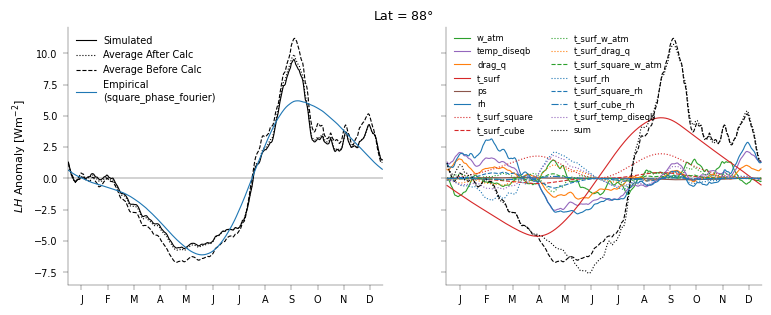

In [199]:
fig, ax = plt.subplots(1,2, figsize=(2*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)

ax[0].plot(ds.time, smooth_func(ds.flux_lhe.isel(lat=plot_lat_ind)-ds.flux_lhe.isel(lat=plot_lat_ind).mean()), color='k', label='Simulated')

ax[0].plot(ds.time, smooth_func(lh_manual['all_cont'].isel(lat=plot_lat_ind)-lh_manual['all_cont'].isel(lat=plot_lat_ind).mean()), color='k',
        linestyle=':', label='Average After Calc')
for i in range(len(ax)):
    ax[i].plot(ds.time, smooth_func(lh_manual['all_cont_av_first'].isel(lat=plot_lat_ind)-
                                    lh_manual['all_cont_av_first'].isel(lat=plot_lat_ind).mean()), color='k', linestyle='--',
            label='Average Before Calc' if i==0 else None)
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].plot(ds.time, gamma_comp['lh']['square_phase_fourier'][plot_lat_ind]-gamma_comp['lh']['square_phase_fourier'][plot_lat_ind].mean(), color=default_colors[0],
           label='Empirical\n(square_phase_fourier)')

for i, key in enumerate(['w_atm', 'temp_diseqb', 'drag_q', 't_surf', 'ps', 'rh']):
    ax[1].plot(ds.time, smooth_func((lh_taylor[key]*(ds[key]-ds_mean[key])).isel(lat=plot_lat_ind)), label=key, color=color_var[key])
ax[1].plot(ds.time, smooth_func((lh_taylor['t_surf_square']*(ds['t_surf']-ds_mean['t_surf'])**2).isel(lat=plot_lat_ind)),
           label='t_surf_square', color=color_var['t_surf'], linestyle=':')
ax[1].plot(ds.time, smooth_func((lh_taylor['t_surf_cube']*(ds['t_surf']-ds_mean['t_surf'])**3).isel(lat=plot_lat_ind)),
           label='t_surf_cube', color=color_var['t_surf'], linestyle='--')
if is_wishe:
    ax[1].plot(ds.time,
               smooth_func((lh_taylor['t_surf_w_atm']*(ds['t_surf']-ds_mean['t_surf'])*(ds['w_atm']-ds_mean['w_atm'])).isel(lat=plot_lat_ind)),
               label='t_surf_w_atm', color=color_var['w_atm'], linestyle=':')
    ax[1].plot(ds.time,
               smooth_func((lh_taylor['t_surf_drag_q']*(ds['t_surf']-ds_mean['t_surf'])*(ds['drag_q']-ds_mean['drag_q'])).isel(lat=plot_lat_ind)),
               label='t_surf_drag_q', color=color_var['drag_q'], linestyle=':')
    ax[1].plot(ds.time,
           smooth_func((lh_taylor['t_surf_square_w_atm']*(ds['t_surf']-ds_mean['t_surf'])**2*(ds['w_atm']-ds_mean['w_atm'])).isel(lat=plot_lat_ind)),
           label='t_surf_square_w_atm', color=color_var['w_atm'], linestyle='--')
    # ax[1].plot(ds.time,
    #            smooth_func((lh_taylor['w_atm_drag_q']*(ds['w_atm']-ds_mean['w_atm'])*(ds['drag_q']-ds_mean['drag_q'])).isel(lat=plot_lat_ind)),
    #            label='w_atm_drag_q', color=color_var['drag_q'], linestyle='--')
ax[1].plot(ds.time,
           smooth_func((lh_taylor['t_surf_rh']*(ds['t_surf']-ds_mean['t_surf'])*(ds['rh']-ds_mean['rh'])).isel(lat=plot_lat_ind)),
           label='t_surf_rh', color=color_var['rh'], linestyle=':')
ax[1].plot(ds.time,
           smooth_func((lh_taylor['t_surf_square_rh']*(ds['t_surf']-ds_mean['t_surf'])**2*(ds['rh']-ds_mean['rh'])).isel(lat=plot_lat_ind)),
           label='t_surf_square_rh', color=color_var['rh'], linestyle='--')
ax[1].plot(ds.time,
           smooth_func((lh_taylor['t_surf_cube_rh']*(ds['t_surf']-ds_mean['t_surf'])**3*(ds['rh']-ds_mean['rh'])).isel(lat=plot_lat_ind)),
           label='t_surf_cube_rh', color=color_var['rh'], linestyle='-.')
ax[1].plot(ds.time,
           smooth_func((lh_taylor['t_surf_temp_diseqb']*(ds['t_surf']-ds_mean['t_surf'])*(ds['temp_diseqb']-ds_mean['temp_diseqb'])
                        ).isel(lat=plot_lat_ind)), label='t_surf_temp_diseqb', color=color_var['temp_diseqb'], linestyle=':')
ax[1].plot(ds.time, smooth_func(lh_taylor['sum'].isel(lat=plot_lat_ind)-lh_taylor['sum'].isel(lat=plot_lat_ind).mean()), color='k', linestyle=':', label='sum')
ax[0].legend()
ax[1].legend(ncol=2, fontsize=6)

ax[0].set_xlim(-1, 360)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('$LH$ Anomaly [Wm$^{-2}$]')
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);

### Sensible Heat
The equation for sensible heat is: $SH = c_p C_t\rho |v|\bigg(T_s - T_a\big(\frac{p_s}{p_a}\big)^{\kappa}\bigg)$

So given that $\rho = p_a/RT_a$ where $T_a = T_s - T_{diseqb}$ and $p_a = \sigma_ap_s$, sensible heat is only a function of 5 variables:

* Surface temperature, $T_s$
* Disequilibrium temperature, $T_{diseqb}$
* Drag coefficient $C_t$
* Wind speed, $|v|$
* Surface pressure $p_s$.

Below we investigate the relative contribution of each of these factors in a taylor series expansion.

In [200]:
def get_sensible_heat(temp_surf, temp_diseqb, wind_speed, drag_coef, p_surf=None, density=None, sigma=sigma_near_surf):
    temp_a = temp_surf - temp_diseqb
    if density is None:
        if p_surf is None:
            raise ValueError('If density not given; surface pressure required')
        p_a = p_surf*sigma
        density = get_density(temp_a, p_a)
    return c_p * drag_coef * density * wind_speed * (temp_surf - temp_a * (1/sigma)**kappa)

In [201]:
sh_manual = {'all_cont': get_annual_zonal_mean(get_sensible_heat(ds_base[0].t_surf, ds_base[0].temp_diseqb, ds_base[0].w_atm,
                                                                 ds_base[0].drag_q, ds_base[0].ps)),
             'all_cont_av_first': get_sensible_heat(ds.t_surf, ds.temp_diseqb, ds.w_atm, ds.drag_q, ds.ps),
             'mean': get_sensible_heat(ds_mean.t_surf, ds_mean.temp_diseqb, ds_mean.w_atm,
                                       ds_mean.drag_q, ds_mean.ps)}
sh_prefactor = c_p*ds_mean.drag_q*ds_mean.w_atm*get_density(ds_mean.temp, sigma_near_surf*ds_mean.ps)
sh_taylor = {'t_surf': sh_prefactor*(1 - sigma_near_surf**kappa - (1/ds_mean.temp)*(ds_mean.t_surf-sigma_near_surf**kappa*ds_mean.temp)),
             'temp_diseqb': sh_prefactor*(sigma_near_surf**kappa + (1/ds_mean.temp)*(ds_mean.t_surf-sigma_near_surf**kappa*ds_mean.temp))}
for key in ['w_atm', 'drag_q', 'ps']:
    sh_taylor[key] = sh_manual['mean']/ds_mean[key]
sh_taylor['sum'] = 0
for key in sh_taylor:
    if key=='sum':
        continue
    sh_taylor['sum'] += (sh_taylor[key]*(ds[key]-ds_mean[key]))
sh_taylor['sum'] = sh_taylor['sum'] + sh_manual['mean']
# temp_diseqb has the largest influence so consider non-linear terms involving it
sh_taylor['temp_diseqb_w_atm']  = sh_taylor['temp_diseqb']/ds_mean.w_atm
sh_taylor['temp_diseqb_drag_q'] = sh_taylor['temp_diseqb']/ds_mean.drag_q
sh_taylor['w_atm_drag_q'] = sh_taylor['w_atm']/ds_mean.drag_q
sh_taylor['w_atm_t_surf'] = sh_taylor['t_surf']/ds_mean.w_atm
sh_taylor['temp_diseqb_square'] = sh_prefactor * ((ds_mean.t_surf-sigma_near_surf**kappa*ds_mean.temp)/ds_mean.temp**2
                                                  + sigma_near_surf**kappa/ds_mean.temp)            # very small effect - just from density term
sh_taylor['temp_diseqb_square'] = sh_taylor['temp_diseqb_square']*0.5
sh_taylor['temp_diseqb_t_surf'] = sh_prefactor * (-(ds_mean.t_surf-sigma_near_surf**kappa*ds_mean.temp)/ds_mean.temp**2
                                                  + (1-sigma_near_surf**kappa)/ds_mean.temp)        # very small effect - just from density term
sh_taylor['sum'] += sh_taylor['temp_diseqb_w_atm'] * (ds['temp_diseqb']-ds_mean['temp_diseqb'])*(ds['w_atm']-ds_mean['w_atm']) + \
    sh_taylor['temp_diseqb_drag_q'] * (ds['temp_diseqb']-ds_mean['temp_diseqb'])*(ds['drag_q']-ds_mean['drag_q']) + \
    sh_taylor['w_atm_drag_q'] * (ds['w_atm']-ds_mean['w_atm'])*(ds['drag_q']-ds_mean['drag_q'])

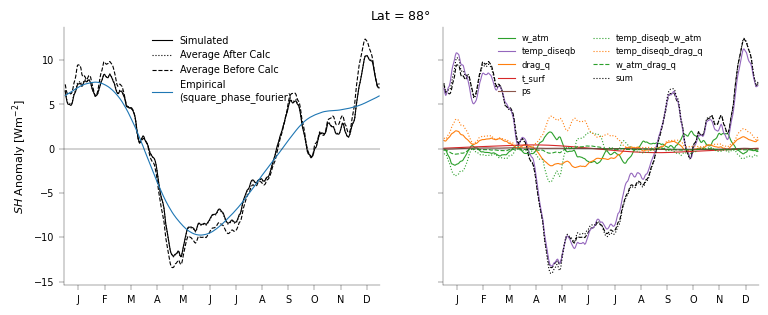

In [202]:
fig, ax = plt.subplots(1,2, figsize=(2*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
ax[0].plot(ds.time, smooth_func(ds.flux_t.isel(lat=plot_lat_ind)-ds.flux_t.isel(lat=plot_lat_ind).mean()), color='k', label='Simulated')

ax[0].plot(ds.time, smooth_func(sh_manual['all_cont'].isel(lat=plot_lat_ind)-sh_manual['all_cont'].isel(lat=plot_lat_ind).mean()), color='k',
        linestyle=':', label='Average After Calc')
ax[0].plot(ds.time, smooth_func(sh_manual['all_cont_av_first'].isel(lat=plot_lat_ind)-
                             sh_manual['all_cont_av_first'].isel(lat=plot_lat_ind).mean()), color='k', linestyle='--',
        label='Average Before Calc')
ax[0].plot(ds.time, gamma_comp['sh']['square_phase_fourier'][plot_lat_ind]-gamma_comp['sh']['square_phase_fourier'][plot_lat_ind].mean(),
           color=default_colors[0],
           label='Empirical\n(square_phase_fourier)')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend()

ax[1].plot(ds.time, smooth_func(sh_manual['all_cont_av_first'].isel(lat=plot_lat_ind)-
                             sh_manual['all_cont_av_first'].isel(lat=plot_lat_ind).mean()), color='k', linestyle='--')
for key in ['w_atm', 'temp_diseqb', 'drag_q', 't_surf', 'ps']:
    ax[1].plot(ds.time, smooth_func((sh_taylor[key]*(ds[key]-ds_mean[key])).isel(lat=plot_lat_ind)), label=key, color=color_var[key])
if is_wishe:
    ax[1].plot(ds.time,
               smooth_func((sh_taylor['temp_diseqb_w_atm']*(ds['temp_diseqb']-ds_mean['temp_diseqb'])*
                            (ds['w_atm']-ds_mean['w_atm'])).isel(lat=plot_lat_ind)),
               label='temp_diseqb_w_atm', color=color_var['w_atm'], linestyle=':')
    ax[1].plot(ds.time,
               smooth_func((sh_taylor['temp_diseqb_drag_q']*(ds['temp_diseqb']-ds_mean['temp_diseqb'])*
                            (ds['drag_q']-ds_mean['drag_q'])).isel(lat=plot_lat_ind)),
               label='temp_diseqb_drag_q', color=color_var['drag_q'], linestyle=':')
    ax[1].plot(ds.time,
               smooth_func((sh_taylor['w_atm_drag_q']*(ds['w_atm']-ds_mean['w_atm'])*
                            (ds['drag_q']-ds_mean['drag_q'])).isel(lat=plot_lat_ind)),
               label='w_atm_drag_q', color=color_var['w_atm'], linestyle='--')
ax[1].plot(ds.time, smooth_func(sh_taylor['sum'].isel(lat=plot_lat_ind)-sh_taylor['sum'].isel(lat=plot_lat_ind).mean()), 
           color=color_var['sum'], linestyle=':', label='sum')
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].legend(ncol=2, fontsize=6)

ax[0].set_xlim(-1, 360)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('$SH$ Anomaly [Wm$^{-2}$]')
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);

### Longwave
#### Emission factor, $\epsilon$
If we say that the longwave emission is given by $\sigma \epsilon T_{a}^4(t)$, this gives an equation for $\epsilon(t) = \frac{LW^{\downarrow}}{\sigma T_a^4}$.

**Seasonal variation in $\epsilon$ is due to lapse rate varying throughout the year.**

In general, $\epsilon$, is a function of optical depth of the atmosphere, as well as atmospheric temperature. This is because $LW^{\downarrow}$ is equal to the radiation reaching the bottom atmospheric level (function of atmospheric temperature and optical depth of upper atmosphere) minus amount absorbed by the bottom atmospheric level (function of optical depth of single level) plus amount emitted by bottom atmospheric level (optical thickness of bottom level multiplied by $\sigma T^4$). 

We see that $\epsilon$ is largest when surface temperature is smallest. This makes sense from Henry 2021b, because in the winter, the lower atmosphere is warmer than the surface, hence emission temperature should be closer to the surface. In the summer however, surface is warmer than the atmosphere and so expect small emission temperature.

The hysteresis is much clearer here, I think it arises due to the advective component. In April and May, sun is moving towards higher latitudes, so pole is colder than surroundings, and thus you advect warmer air from the south increasing the low level atmospheric temperature resulting in a large $\epsilon$. In December and January, sun is moving south so now less of a temperature gradient to the south and low level atmospheric temperature is not increased much by advection, resulting in small $\epsilon$.

This hysteresis is not apparent in the summer because the summer is in radiative-convective equilibrium.

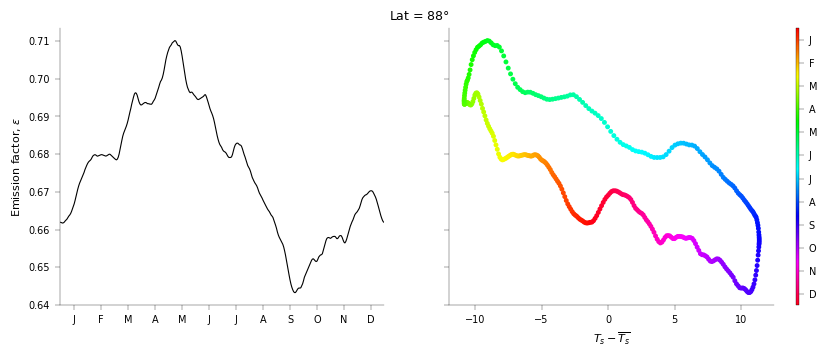

In [203]:
fig, ax = plt.subplots(1,2, figsize=(2*1.5*width['one_col'], 1.5*width['one_col']/ar), sharey=True)
ax[0].plot(ds.time, smooth_func(ds.emission_factor[:, plot_lat_ind]), color='k')
im = ax[1].scatter(smooth_func(t_surf_anom[plot_lat_ind]), smooth_func(ds.emission_factor[:, plot_lat_ind]), c=ds.time, cmap='hsv')
ax[0].set_xlim(-1, 360)
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Emission factor, $\epsilon$')
ax[1].set_xlabel('$T_s - \overline{T_s}$')
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);

#### Taylor Expansion
The equation for sensible heat is: $LW^{\uparrow}-LW^{\downarrow} = \sigma(T_s^4-\epsilon T_a^4)$

So it is only a function of 2 variables:

* Surface temperature, $T_s$
* Emission factor, $\epsilon$

Below we investigate the relative contribution of each of these factors in a taylor series expansion.

In [204]:
def get_longwave_net(temp_surf, temp_diseqb, emission_factor):
    temp_a = temp_surf - temp_diseqb
    return Stefan_Boltzmann * (temp_surf**4 - emission_factor * temp_a**4)

In [205]:
lw_manual = {'all_cont': get_annual_zonal_mean(get_longwave_net(ds_base[0].t_surf, ds_base[0].temp_diseqb, ds_base[0].emission_factor)),
             'all_cont_av_first': get_longwave_net(ds.t_surf, ds.temp_diseqb, ds.emission_factor),
             'mean': get_longwave_net(ds_mean.t_surf, ds_mean.temp_diseqb, ds_mean.emission_factor)}
lw_taylor = {'t_surf': 4 * Stefan_Boltzmann * (ds_mean.t_surf ** 3 - ds_mean.emission_factor * ds_mean.temp**3),
             'temp_diseqb': 4 * Stefan_Boltzmann * ds_mean.emission_factor * ds_mean.temp**3,
             'emission_factor': -Stefan_Boltzmann * ds_mean.temp ** 4,
             'sum': 0}
for key in lw_taylor:
    if key=='sum':
        continue
    lw_taylor['sum'] += (lw_taylor[key]*(ds[key]-ds_mean[key]))
lw_taylor['sum'] = lw_taylor['sum'] + lw_manual['mean']
# temp_diseqb has the largest influence so consider non-linear terms involving it
lw_taylor['t_surf_square'] = 12 * Stefan_Boltzmann * (ds_mean.t_surf ** 2 - ds_mean.emission_factor * ds_mean.temp**2)
lw_taylor['t_surf_square'] = lw_taylor['t_surf_square'] * 0.5
lw_taylor['t_surf_temp_diseqb'] = 12 * Stefan_Boltzmann * ds_mean.emission_factor * ds_mean.temp**2
lw_taylor['t_surf_emission_factor'] = -4 * Stefan_Boltzmann * ds_mean.temp ** 3
lw_taylor['temp_diseqb_emission_factor'] = 4 * Stefan_Boltzmann * ds_mean.temp ** 3
lw_taylor['sum'] += lw_taylor['t_surf_square']*(ds['t_surf']-ds_mean['t_surf'])**2 + \
                    lw_taylor['t_surf_temp_diseqb']*(ds['t_surf']-ds_mean['t_surf'])*(ds['temp_diseqb']-ds_mean['temp_diseqb']) + \
    lw_taylor['t_surf_emission_factor']*(ds['t_surf']-ds_mean['t_surf'])*(ds['emission_factor']-ds_mean['emission_factor'])

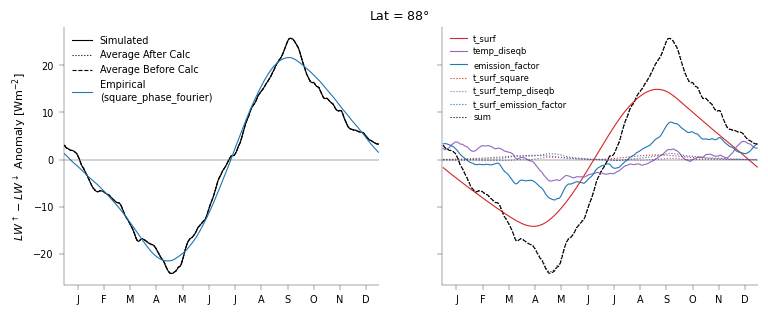

In [206]:
fig, ax = plt.subplots(1,2, figsize=(2*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
ax[0].plot(ds.time, smooth_func(ds.lw_net.isel(lat=plot_lat_ind)-ds.lw_net.isel(lat=plot_lat_ind).mean()), color='k', label='Simulated')

ax[0].plot(ds.time, smooth_func(lw_manual['all_cont'].isel(lat=plot_lat_ind)-lw_manual['all_cont'].isel(lat=plot_lat_ind).mean()), color='k',
        linestyle=':', label='Average After Calc')
ax[0].plot(ds.time, smooth_func(lw_manual['all_cont_av_first'].isel(lat=plot_lat_ind)-
                             lw_manual['all_cont_av_first'].isel(lat=plot_lat_ind).mean()), color='k', linestyle='--',
        label='Average Before Calc')
ax[0].plot(ds.time, gamma_comp['lw']['square_phase_fourier'][plot_lat_ind]-gamma_comp['lw']['square_phase_fourier'][plot_lat_ind].mean(),
           color=default_colors[0],
           label='Empirical\n(square_phase_fourier)')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend()

ax[1].plot(ds.time, smooth_func(lw_manual['all_cont_av_first'].isel(lat=plot_lat_ind)-
                                lw_manual['all_cont_av_first'].isel(lat=plot_lat_ind).mean()), color='k', linestyle='--')
for key in ['t_surf', 'temp_diseqb', 'emission_factor']:
    ax[1].plot(ds.time, smooth_func((lw_taylor[key]*(ds[key]-ds_mean[key])).isel(lat=plot_lat_ind)), label=key, color=color_var[key])
ax[1].plot(ds.time,
           smooth_func((lw_taylor['t_surf_square']*(ds['t_surf']-ds_mean['t_surf'])**2).isel(lat=plot_lat_ind)),
           label='t_surf_square', color=color_var['t_surf'], linestyle=':')
ax[1].plot(ds.time,
           smooth_func((lw_taylor['t_surf_temp_diseqb']*(ds['t_surf']-ds_mean['t_surf'])*
                        (ds['temp_diseqb']-ds_mean['temp_diseqb'])).isel(lat=plot_lat_ind)),
           label='t_surf_temp_diseqb', color=color_var['temp_diseqb'], linestyle=':')
ax[1].plot(ds.time,
           smooth_func((lw_taylor['t_surf_emission_factor']*(ds['t_surf']-ds_mean['t_surf'])*
                        (ds['emission_factor']-ds_mean['emission_factor'])).isel(lat=plot_lat_ind)),
           label='t_surf_emission_factor', color=color_var['emission_factor'], linestyle=':')
ax[1].plot(ds.time, smooth_func(lw_taylor['sum'].isel(lat=plot_lat_ind)-lw_taylor['sum'].isel(lat=plot_lat_ind).mean()), 
           color=color_var['sum'], linestyle=':', label='sum')
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].legend(fontsize=6)

ax[0].set_xlim(-1, 360)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('$LW^{\\uparrow} - LW^{\\downarrow}$ Anomaly [Wm$^{-2}$]')
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);

### Relating variables to temperature
In the taylor series above, it appears that the variables other than `t_surf` have linear taylor series contributions that look similar to `t_surf`, and thus it seems we can do a polynomial fit of the other variables in terms of `t_surf` i.e. find coefficients $a$, $b$ and $b_{phase}$ such that $|v| \approx a + bT'(t) + b_{phase}T'(t-\mathcal{T}/4)$ for `w_atm`, and repeat for all 6 variables in the taylor expansions:

* Disequilibrium temperature, $T_{diseqb}$
* Relative humidity, $r_a$
* Drag coefficient $C_t$
* Wind speed, $|v|$
* Surface pressure $p_s$
* Emission factor, $\epsilon$

The fits are shown below, as well as the option to plot each variable's taylor series contribution to each flux (`show_flux_taylor=True`).

In [207]:
var_fit_method = 'square_phase_fourier'
var_anom_approx_params = {key: np.zeros((n_lat, 6)) for key in ['rh', 'temp_diseqb', 'w_atm', 'drag_q', 'ps', 'emission_factor']}
var_anom_approx = {key: np.zeros((n_lat, n_time)) for key in var_anom_approx_params}
taylor_linear_coefs = {'lh': {key: lh_taylor[key].to_numpy() for key in lh_taylor if key in var_anom_approx}, 
                       'sh': {key: sh_taylor[key].to_numpy() for key in sh_taylor if key in var_anom_approx}, 
                       'lw': {key: lw_taylor[key].to_numpy() for key in lw_taylor if key in var_anom_approx}}
taylor_linear = {'lh': lh_taylor['sum'].to_numpy(),'sh': sh_taylor['sum'].to_numpy(), 'lw': lw_taylor['sum'].to_numpy()}
gamma_comp_taylor_approx_params = {'lh': {key: np.zeros((n_lat, 5)) for key in ['rh', 'temp_diseqb', 'w_atm', 'drag_q', 'ps']},
                                   'sh': {key: np.zeros((n_lat, 5)) for key in ['temp_diseqb', 'w_atm', 'drag_q', 'ps']},
                                   'lw': {key: np.zeros((n_lat, 5)) for key in ['emission_factor', 'temp_diseqb']}}
gamma_comp_taylor_approx = {key2: {key: np.zeros((n_lat, n_time)) for key in gamma_comp_taylor_approx_params[key2]} 
                            for key2 in gamma_comp_taylor_approx_params}
    
for i in range(n_lat):
    for key in var_anom_approx_params:
        if 'square' in var_fit_method:
            var_anom_approx_params[key][i, [2, 3, 4, 5]], param_fourier_amp_use, param_fourier_phase_use = \
                numerical.polyfit_phase(t_surf_anom[i], ds[key].isel(lat=i)-ds[key].isel(lat=i).mean(), 2, resample=resample,
                                        fourier_harmonics=np.asarray([2]))
        else:
            var_anom_approx_params[key][i, [2, 4, 5]], param_fourier_amp_use, param_fourier_phase_use = \
                numerical.polyfit_phase(t_surf_anom[i], ds[key].isel(lat=i)-ds[key].isel(lat=i).mean(), 1, resample=resample,
                                        fourier_harmonics=np.asarray([2]))
        var_anom_approx[key][i] = numerical.polyval_phase(var_anom_approx_params[key][i][2:], t_surf_anom[i],
                                                          coefs_fourier_amp=param_fourier_amp_use, coefs_fourier_phase=param_fourier_phase_use)
        var_anom_approx_params[key][i, 0], var_anom_approx_params[key][i, 1] = fourier.coef_conversion(param_fourier_amp_use[2],
                                                                                                       param_fourier_phase_use[1])
        for key2 in gamma_comp_taylor_approx:
            if key in gamma_comp_taylor_approx[key2]:
                gamma_comp_taylor_approx_params[key2][key][i] = taylor_linear_coefs[key2][key][i] * var_anom_approx_params[key][i, :-1]
                # Add zero below because constant term in polyfit i.e. power 0 needs to be set to 0 as lh_taylor gives anomalies
                param_fourier_amp_use, param_fourier_phase_use = fourier.coef_conversion(cos_coef=gamma_comp_taylor_approx_params[key2][key][i, 0],
                                                                                         sin_coef=gamma_comp_taylor_approx_params[key2][key][i, 1])
                gamma_comp_taylor_approx[key2][key][i] = numerical.polyval_phase(np.append(gamma_comp_taylor_approx_params[key2][key][i, 2:], 0),
                                                                                 t_surf_anom[i], coefs_fourier_amp=[0, 0, param_fourier_amp_use],
                                                                                 coefs_fourier_phase=[0, param_fourier_phase_use])

# for t_surf make first param 0 as no phase shift for t_surf contribution to LH
gamma_comp_taylor_approx_params['lh']['t_surf'] = np.vstack((np.zeros((4, n_lat)), lh_taylor['t_surf'].to_numpy())).transpose()
gamma_comp_taylor_approx_params['sh']['t_surf'] = np.vstack((np.zeros((4, n_lat)), sh_taylor['t_surf'].to_numpy())).transpose()
gamma_comp_taylor_approx_params['lw']['t_surf'] = np.vstack((np.zeros((4, n_lat)), lw_taylor['t_surf'].to_numpy())).transpose()

# Add direct squared term - very small for sensible heat
gamma_comp_taylor_approx_params['lh']['t_surf'][:, 3] = lh_taylor['t_surf_square']
gamma_comp_taylor_approx_params['lw']['t_surf'][:, 3] = lw_taylor['t_surf_square']

# Add squared term from significiant non-linear contributions
gamma_comp_taylor_approx_params['lh']['t_surf_w_atm'] = np.zeros_like(gamma_comp_taylor_approx_params['lh']['t_surf'])
gamma_comp_taylor_approx_params['lh']['t_surf_w_atm'][:, 3] = lh_taylor['t_surf_w_atm'] * var_anom_approx_params['w_atm'][:, -2]
gamma_comp_taylor_approx_params['lh']['t_surf_drag_q'] = np.zeros_like(gamma_comp_taylor_approx_params['lh']['t_surf'])
gamma_comp_taylor_approx_params['lh']['t_surf_drag_q'][:, 3] = lh_taylor['t_surf_drag_q'] * var_anom_approx_params['drag_q'][:, -2]
gamma_comp_taylor_approx_params['lh']['t_surf_rh'] = np.zeros_like(gamma_comp_taylor_approx_params['lh']['t_surf'])
gamma_comp_taylor_approx_params['lh']['t_surf_rh'][:, 3] = lh_taylor['t_surf_rh'] * var_anom_approx_params['rh'][:, -2]
gamma_comp_taylor_approx_params['lh']['t_surf_temp_diseqb'] = np.zeros_like(gamma_comp_taylor_approx_params['lh']['t_surf'])
gamma_comp_taylor_approx_params['lh']['t_surf_temp_diseqb'][:, 3] = lh_taylor['t_surf_temp_diseqb'] * var_anom_approx_params['temp_diseqb'][:, -2]
gamma_comp_taylor_approx_params['lh']['w_atm_drag_q'] = np.zeros_like(gamma_comp_taylor_approx_params['lh']['t_surf'])
gamma_comp_taylor_approx_params['lh']['w_atm_drag_q'][:, 3] = lh_taylor['w_atm_drag_q'] * var_anom_approx_params['drag_q'][:, -2] * \
                                                                   var_anom_approx_params['w_atm'][:, -2]
# gamma_comp_taylor_approx_params['lh']['t_surf_square_w_atm'] = np.zeros_like(gamma_comp_taylor_approx_params['lh']['t_surf'])
# gamma_comp_taylor_approx_params['lh']['t_surf_square_w_atm'][:, 3] = lh_taylor['t_surf_square_w_atm'] * var_anom_approx_params['w_atm'][:, -1]

gamma_comp_taylor_approx_params['sh']['temp_diseqb_w_atm'] = np.zeros_like(gamma_comp_taylor_approx_params['sh']['t_surf'])
gamma_comp_taylor_approx_params['sh']['temp_diseqb_w_atm'][:, 3] = sh_taylor['temp_diseqb_w_atm'] * var_anom_approx_params['w_atm'][:, -2] * \
                                                                   var_anom_approx_params['temp_diseqb'][:, -2]
gamma_comp_taylor_approx_params['sh']['temp_diseqb_drag_q'] = np.zeros_like(gamma_comp_taylor_approx_params['sh']['t_surf'])
gamma_comp_taylor_approx_params['sh']['temp_diseqb_drag_q'][:, 3] = sh_taylor['temp_diseqb_drag_q'] * var_anom_approx_params['drag_q'][:, -2] * \
                                                                   var_anom_approx_params['temp_diseqb'][:, -2]
gamma_comp_taylor_approx_params['sh']['w_atm_drag_q'] = np.zeros_like(gamma_comp_taylor_approx_params['sh']['t_surf'])
gamma_comp_taylor_approx_params['sh']['w_atm_drag_q'][:, 3] = sh_taylor['w_atm_drag_q'] * var_anom_approx_params['drag_q'][:, -2] * \
                                                                   var_anom_approx_params['w_atm'][:, -2]
gamma_comp_taylor_approx_params['sh']['t_surf_w_atm'] = np.zeros_like(gamma_comp_taylor_approx_params['sh']['t_surf'])
gamma_comp_taylor_approx_params['sh']['t_surf_w_atm'][:, 3] = sh_taylor['w_atm_t_surf'] * var_anom_approx_params['w_atm'][:, -2]

gamma_comp_taylor_approx_params['lw']['t_surf_temp_diseqb'] = np.zeros_like(gamma_comp_taylor_approx_params['lw']['t_surf'])
gamma_comp_taylor_approx_params['lw']['t_surf_temp_diseqb'][:, 3] = lw_taylor['t_surf_temp_diseqb'] * var_anom_approx_params['temp_diseqb'][:, -2]
gamma_comp_taylor_approx_params['lw']['t_surf_emission_factor'] = np.zeros_like(gamma_comp_taylor_approx_params['lw']['t_surf'])
gamma_comp_taylor_approx_params['lw']['t_surf_emission_factor'][:, 3] = lw_taylor['t_surf_emission_factor'] * \
                                                                    var_anom_approx_params['emission_factor'][:, -2]
gamma_comp_taylor_approx_params['lw']['temp_diseqb_emission_factor'] = np.zeros_like(gamma_comp_taylor_approx_params['lw']['t_surf'])
gamma_comp_taylor_approx_params['lw']['temp_diseqb_emission_factor'][:, 3] = lw_taylor['temp_diseqb_emission_factor'] * \
                                                                             var_anom_approx_params['emission_factor'][:, -2] * \
                                                                   var_anom_approx_params['temp_diseqb'][:, -2]

# Add fourier coefficient contribution from significant non-linear contributions
for i in range(n_lat):
    # Latent Heat
    var_nl = lh_taylor['t_surf_w_atm'] * (ds['t_surf']-ds_mean['t_surf']) * (ds['w_atm']-ds_mean['w_atm'])
    param_fourier_amp_use, param_fourier_phase_use = numerical.polyfit_phase(t_surf_anom[i], var_nl[i], 2, fourier_harmonics=np.asarray([2]))[1:]
    gamma_comp_taylor_approx_params['lh']['t_surf_w_atm'][i, :2] = fourier.coef_conversion(param_fourier_amp_use[-1], param_fourier_phase_use[-1])

    var_nl = lh_taylor['t_surf_drag_q'] * (ds['t_surf']-ds_mean['t_surf']) * (ds['drag_q']-ds_mean['drag_q'])
    param_fourier_amp_use, param_fourier_phase_use = numerical.polyfit_phase(t_surf_anom[i], var_nl[i], 2, fourier_harmonics=np.asarray([2]))[1:]
    gamma_comp_taylor_approx_params['lh']['t_surf_drag_q'][i, :2] = fourier.coef_conversion(param_fourier_amp_use[-1], param_fourier_phase_use[-1])

    var_nl = lh_taylor['t_surf_rh'] * (ds['t_surf']-ds_mean['t_surf']) * (ds['rh']-ds_mean['rh'])
    param_fourier_amp_use, param_fourier_phase_use = numerical.polyfit_phase(t_surf_anom[i], var_nl[i], 2, fourier_harmonics=np.asarray([2]))[1:]
    gamma_comp_taylor_approx_params['lh']['t_surf_rh'][i, :2] = fourier.coef_conversion(param_fourier_amp_use[-1], param_fourier_phase_use[-1])

    var_nl = lh_taylor['t_surf_temp_diseqb'] * (ds['t_surf']-ds_mean['t_surf']) * (ds['temp_diseqb']-ds_mean['temp_diseqb'])
    param_fourier_amp_use, param_fourier_phase_use = numerical.polyfit_phase(t_surf_anom[i], var_nl[i], 2, fourier_harmonics=np.asarray([2]))[1:]
    gamma_comp_taylor_approx_params['lh']['t_surf_temp_diseqb'][i, :2] = fourier.coef_conversion(param_fourier_amp_use[-1], param_fourier_phase_use[-1])

    # Sensible Heat
    var_nl = sh_taylor['temp_diseqb_w_atm'] * (ds['temp_diseqb']-ds_mean['temp_diseqb']) * (ds['w_atm']-ds_mean['w_atm'])
    param_fourier_amp_use, param_fourier_phase_use = numerical.polyfit_phase(t_surf_anom[i], var_nl[i], 2, fourier_harmonics=np.asarray([2]))[1:]
    gamma_comp_taylor_approx_params['sh']['temp_diseqb_w_atm'][i, :2] = fourier.coef_conversion(param_fourier_amp_use[-1], param_fourier_phase_use[-1])

    var_nl = sh_taylor['temp_diseqb_drag_q'] * (ds['temp_diseqb']-ds_mean['temp_diseqb']) * (ds['drag_q']-ds_mean['drag_q'])
    param_fourier_amp_use, param_fourier_phase_use = numerical.polyfit_phase(t_surf_anom[i], var_nl[i], 2, fourier_harmonics=np.asarray([2]))[1:]
    gamma_comp_taylor_approx_params['sh']['temp_diseqb_drag_q'][i, :2] = fourier.coef_conversion(param_fourier_amp_use[-1], param_fourier_phase_use[-1])

    var_nl = sh_taylor['w_atm_drag_q'] * (ds['w_atm']-ds_mean['w_atm']) * (ds['drag_q']-ds_mean['drag_q'])
    param_fourier_amp_use, param_fourier_phase_use = numerical.polyfit_phase(t_surf_anom[i], var_nl[i], 2, fourier_harmonics=np.asarray([2]))[1:]
    gamma_comp_taylor_approx_params['sh']['w_atm_drag_q'][i, :2] = fourier.coef_conversion(param_fourier_amp_use[-1], param_fourier_phase_use[-1])

    # Longwave
    var_nl = lw_taylor['t_surf_temp_diseqb'] * (ds['t_surf']-ds_mean['t_surf']) * (ds['temp_diseqb']-ds_mean['temp_diseqb'])
    param_fourier_amp_use, param_fourier_phase_use = numerical.polyfit_phase(t_surf_anom[i], var_nl[i], 2, fourier_harmonics=np.asarray([2]))[1:]
    gamma_comp_taylor_approx_params['lw']['t_surf_temp_diseqb'][i, :2] = fourier.coef_conversion(param_fourier_amp_use[-1],
                                                                                                 param_fourier_phase_use[-1])

    var_nl = lw_taylor['t_surf_emission_factor'] * (ds['t_surf']-ds_mean['t_surf']) * (ds['emission_factor']-ds_mean['emission_factor'])
    param_fourier_amp_use, param_fourier_phase_use = numerical.polyfit_phase(t_surf_anom[i], var_nl[i], 2, fourier_harmonics=np.asarray([2]))[1:]
    gamma_comp_taylor_approx_params['lw']['t_surf_emission_factor'][i, :2] = fourier.coef_conversion(param_fourier_amp_use[-1],
                                                                                                     param_fourier_phase_use[-1])

    var_nl = lw_taylor['temp_diseqb_emission_factor'] * (ds['temp_diseqb']-ds_mean['temp_diseqb']) * (ds['emission_factor']-ds_mean['emission_factor'])
    param_fourier_amp_use, param_fourier_phase_use = numerical.polyfit_phase(t_surf_anom[i], var_nl[i], 2, fourier_harmonics=np.asarray([2]))[1:]
    gamma_comp_taylor_approx_params['lw']['temp_diseqb_emission_factor'][i, :2] = fourier.coef_conversion(param_fourier_amp_use[-1],
                                                                                                          param_fourier_phase_use[-1])

for key in gamma_comp_taylor_approx_params:
    gamma_comp_taylor_approx[key]['t_surf'] = gamma_comp_taylor_approx_params[key]['t_surf'][:, -1:] * t_surf_anom
    gamma_comp_taylor_approx_params[key]['sum'] = np.sum([gamma_comp_taylor_approx_params[key][key2] for key2 in
                                                          gamma_comp_taylor_approx_params[key]], axis=0)
    gamma_comp_taylor_approx[key]['sum'] = np.sum([gamma_comp_taylor_approx[key][key2] for key2 in gamma_comp_taylor_approx[key]], axis=0)

gamma_comp_taylor_approx['lh']['sum'] = gamma_comp_taylor_approx['lh']['sum'] + lh_manual['mean'].to_numpy()[:, np.newaxis]
gamma_comp_taylor_approx['sh']['sum'] = gamma_comp_taylor_approx['sh']['sum'] + sh_manual['mean'].to_numpy()[:, np.newaxis]
gamma_comp_taylor_approx['lw']['sum'] = gamma_comp_taylor_approx['lw']['sum'] + lw_manual['mean'].to_numpy()[:, np.newaxis]

In [208]:
# var_anom_approx_params = {key: np.zeros((n_lat, 3)) for key in ['rh', 'temp_diseqb', 'w_atm', 'drag_q', 'ps', 'emission_factor']}
# var_anom_approx = {key: np.zeros((n_lat, n_time)) for key in var_anom_approx_params}
# gamma_comp_taylor_approx_params = {'lh': {key: np.zeros((n_lat, 3)) for key in ['rh', 'temp_diseqb', 'w_atm', 'drag_q', 'ps']},
#                                    'sh': {key: np.zeros((n_lat, 3)) for key in ['temp_diseqb', 'w_atm', 'drag_q', 'ps']},
#                                    'lw': {key: np.zeros((n_lat, 3)) for key in ['emission_factor']}}
# gamma_comp_taylor_approx = {key2: {key: np.zeros((n_lat, n_time)) for key in gamma_comp_taylor_approx_params[key2]}
#                             for key2 in gamma_comp_taylor_approx_params}
# lh_taylor_approx_params = {key: np.zeros((n_lat, 2)) for key in var_anom_approx_params}
# lh_taylor_approx = {key: np.zeros((n_lat, n_time)) for key in var_anom_approx_params}
# # for t_surf make first param 0 as no phase shift for t_surf contribution to LH
# lh_taylor_approx_params['t_surf'] = np.vstack((np.zeros(n_lat), lh_taylor['t_surf'].to_numpy())).transpose()
# lh_taylor_approx['t_surf'] = lh_taylor_approx_params['t_surf'][:, 1:] * t_surf_anom
#
# for key in var_anom_approx_params:
#     for i in range(n_lat):
#         var_anom_approx_params[key][i] = numerical.polyfit_phase(t_surf_anom[i], ds[key].isel(lat=i)-ds[key].isel(lat=i).mean(), 1, ds.time.to_numpy())
#         var_anom_approx[key][i] = numerical.apply_polyfit_phase(t_surf_anom[i], var_anom_approx_params[key][i])
#         lh_taylor_approx_params[key][i] = float(lh_taylor[key][i]) * var_anom_approx_params[key][i][:2]
#         # Add zero below because constant term in polyfit i.e. power 0 needs to be set to 0 as lh_taylor gives anomalies
#         lh_taylor_approx[key][i] = numerical.apply_polyfit_phase(t_surf_anom[i], np.append(lh_taylor_approx_params[key][i], 0))
# lh_taylor_approx_params['sum'] = np.sum([lh_taylor_approx_params[key] for key in lh_taylor_approx_params], axis=0)
# lh_taylor_approx['sum'] = np.sum([lh_taylor_approx[key] for key in lh_taylor_approx], axis=0)

/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_54298/4020028200.py:37: UserWarning: Adding colorbar to a different Figure <Figure size 960x360 with 3 Axes> than <Figure size 896x336 with 3 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, ax=ax.ravel().tolist() if len(ax)>1 else ax[0], aspect=100, pad=0.03, fraction=0.01)


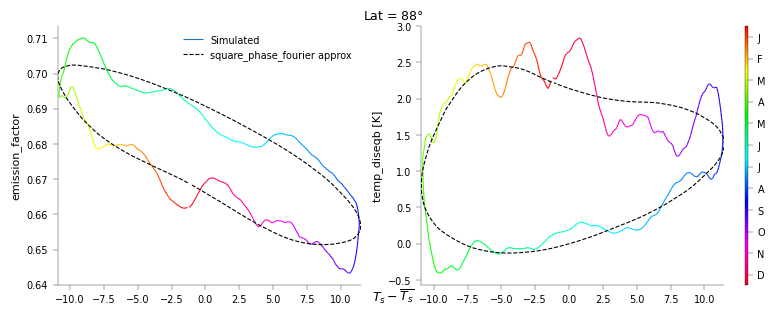

In [209]:
key_flux_plot = 'lw'
ignore_var_plot = ['ps', 't_surf_w_atm', 't_surf_temp_diseqb', 't_surf_emission_factor',
                   'temp_diseqb_emission_factor', 't_surf_drag_q', 't_surf_rh', 'w_atm_drag_q', 'temp_diseqb_w_atm',
                   'temp_diseqb_drag_q']         # variables that you don't want to plot
show_flux_taylor = False       # if True will plot linear taylor series contribution to LH, otherwise will plot the variable
var_keys_plot = [key for key in gamma_comp_taylor_approx_params[key_flux_plot] if key!='t_surf' and key != 'sum' and key not in ignore_var_plot]
if len(var_keys_plot)>3:
    fig, ax = plt.subplots(2,int(np.ceil(len(var_keys_plot)/2)), 
                           figsize=(int(np.ceil(len(var_keys_plot)/2))*im_sz*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True,
                           sharey=show_flux_taylor)
    ax = ax.flatten()
else:
    fig, ax = plt.subplots(1,len(var_keys_plot), figsize=(len(var_keys_plot)*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True,
                           sharey=show_flux_taylor)
    if len(var_keys_plot)==1:
        ax = [ax]
for i, key in enumerate(var_keys_plot):
    if show_flux_taylor:
        colored_line(smooth_func(t_surf_anom[plot_lat_ind]), smooth_func((taylor_linear_coefs[key_flux_plot][key] * 
                                                                          (ds[key]-ds_mean[key])).isel(lat=plot_lat_ind)), c=ds.time, 
                     ax=ax[i], cmap='hsv', label='Simulated')
        ax[i].plot(t_surf_anom[plot_lat_ind], gamma_comp_taylor_approx[key_flux_plot][key][plot_lat_ind]-gamma_comp_taylor_approx[key_flux_plot][key][plot_lat_ind].mean(), color='k',
                   linestyle=linestyle_approx['linear_phase'], label='square_phase approx')
        ax[i].axhline(0, color='k', lw=ax_linewidth)
        ax[i].set_title(key)
    else:
        colored_line(smooth_func(t_surf_anom[plot_lat_ind]), smooth_func(ds[key].isel(lat=plot_lat_ind)), c=ds.time, 
                     ax=ax[i], cmap='hsv', label='Simulated')
        ax[i].plot(t_surf_anom[plot_lat_ind], var_anom_approx[key][plot_lat_ind]+float(ds[key].isel(lat=plot_lat_ind).mean()), color='k',
                   linestyle=linestyle_approx['linear_phase'], label=f'{var_fit_method} approx')
        ax[i].set_ylabel(key+(f' {var_unit_labels[key]}' if var_unit_labels[key] is not None else ''))
ax[0].set_xlim(t_surf_anom[plot_lat_ind].min(), t_surf_anom[plot_lat_ind].max())
ax[0].legend()
if show_flux_taylor:
    fig.supylabel(f'${key_flux_plot.upper()} - \overline{"{"+key_flux_plot.upper()+"}"}$ Contribution '+'[Wm$^{-2}$]', fontsize=9, x=0.07)
fig.supxlabel('$T_s - \overline{T_s}$', fontsize=9, y=0.05)
cbar = fig.colorbar(im, ax=ax.ravel().tolist() if len(ax)>1 else ax[0], aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);

### Breakdown of $\lambda$ and $\lambda_{phase}$
Below for a given flux, I plot the contributions from the different variables to the final $\lambda$ and $\lambda_{phase}$, assuming a linear taylor series expansion. The appropriateness of the linear taylor series approximation can be seen by how closer the sum of all linear terms (black solid line) is to the empirical fit (black dotted line).

It is clear that $\lambda$ does not just come from the `t_surf` component of the linear taylor series expansion.

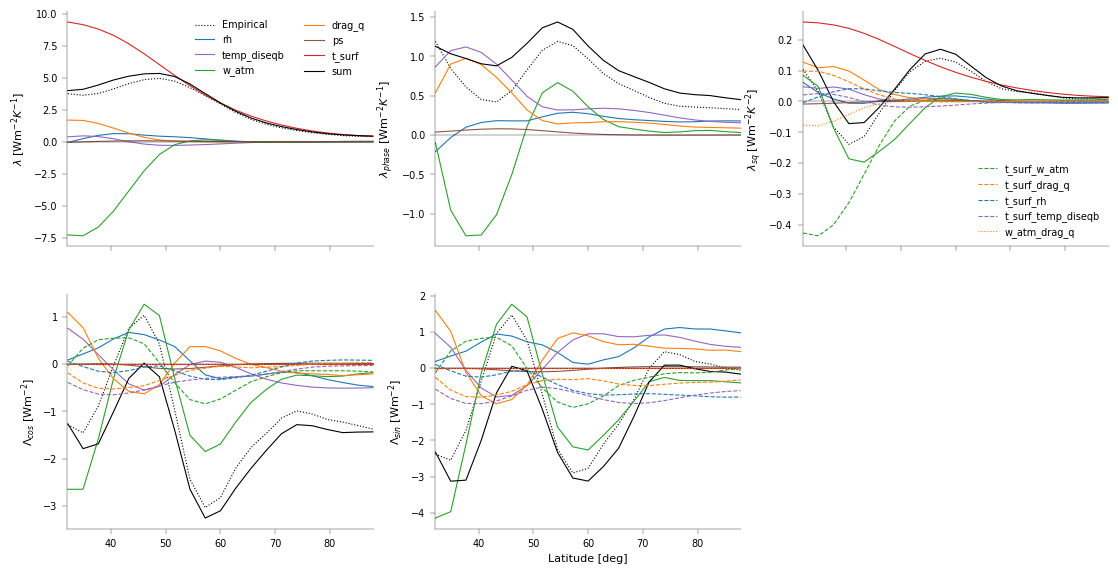

In [225]:
key_flux_plot = 'lh'
show_non_linear = True
arg_ind = [4, 2, 3, 0, 1]
fig, ax = plt.subplots(2, 3, figsize=(im_sz*3*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True)
ax = ax.flatten()
ax[-1].remove()
for i in range(len(arg_ind)):
    # for key2 in gamma_comp_params:
    ax[i].plot(ds.lat, gamma_comp_params[key_flux_plot]['square_phase_fourier'][:, arg_ind[i]], color='k', label='Empirical' if i==0 else None,
               linestyle=':')
    for key in gamma_comp_taylor_approx_params[key_flux_plot]:
        if key == 't_surf' and i==1 or 't_surf_' in key or 'temp_diseqb_' in key or 'w_atm_' in key:
            continue
        ax[i].plot(ds.lat, gamma_comp_taylor_approx_params[key_flux_plot][key][:, arg_ind[i]], color=color_var[key], label=key if i==0 else None,
                   linestyle=None)
    ax[i].axhline(0, color='k', lw=ax_linewidth)

# Plot non-linear contributions to squared factor, cos factor and sin factor
if show_non_linear:
    for i in [2, 3, 4]:
        if key_flux_plot == 'lh':
            ax[i].plot(ds.lat, gamma_comp_taylor_approx_params[key_flux_plot]['t_surf_w_atm'][:, arg_ind[i]], color=color_var['w_atm'],
                       label='t_surf_w_atm', linestyle='--')
            ax[i].plot(ds.lat, gamma_comp_taylor_approx_params[key_flux_plot]['t_surf_drag_q'][:, arg_ind[i]], color=color_var['drag_q'],
                       label='t_surf_drag_q', linestyle='--')
            ax[i].plot(ds.lat, gamma_comp_taylor_approx_params[key_flux_plot]['t_surf_rh'][:, arg_ind[i]], color=color_var['rh'],
                       label='t_surf_rh', linestyle='--')
            ax[i].plot(ds.lat, gamma_comp_taylor_approx_params[key_flux_plot]['t_surf_temp_diseqb'][:, arg_ind[i]], color=color_var['temp_diseqb'],
                       label='t_surf_temp_diseqb', linestyle='--')
            ax[i].plot(ds.lat, gamma_comp_taylor_approx_params[key_flux_plot]['w_atm_drag_q'][:, arg_ind[i]], color=color_var['drag_q'],
                       label='w_atm_drag_q', linestyle=':')
        if key_flux_plot == 'sh':
            ax[i].plot(ds.lat, gamma_comp_taylor_approx_params[key_flux_plot]['temp_diseqb_w_atm'][:, arg_ind[i]], color=color_var['w_atm'],
                       label='temp_diseqb_w_atm', linestyle='--')
            ax[i].plot(ds.lat, gamma_comp_taylor_approx_params[key_flux_plot]['temp_diseqb_drag_q'][:, arg_ind[i]], color=color_var['drag_q'],
                       label='temp_diseqb_drag_q', linestyle='--')
            ax[i].plot(ds.lat, gamma_comp_taylor_approx_params[key_flux_plot]['w_atm_drag_q'][:, arg_ind[i]], color=color_var['w_atm'],
                       label='w_atm_drag_q', linestyle=':')
            ax[i].plot(ds.lat, gamma_comp_taylor_approx_params[key_flux_plot]['t_surf_w_atm'][:, arg_ind[i]], color=color_var['t_surf'],
                       label='t_surf_w_atm', linestyle='--')
        if key_flux_plot == 'lw':
            ax[i].plot(ds.lat, gamma_comp_taylor_approx_params[key_flux_plot]['t_surf_temp_diseqb'][:, arg_ind[i]], color=color_var['temp_diseqb'],
                       linestyle='--', label='t_surf_temp_diseqb')
            ax[i].plot(ds.lat, gamma_comp_taylor_approx_params[key_flux_plot]['t_surf_emission_factor'][:, arg_ind[i]], color=color_var['emission_factor'],
                       label='t_surf_emission_factor', linestyle='--')
            ax[i].plot(ds.lat, gamma_comp_taylor_approx_params[key_flux_plot]['temp_diseqb_emission_factor'][:, arg_ind[i]], color=color_var['emission_factor'],
                       label='temp_diseqb_emission_factor', linestyle=':')
ax[0].legend(ncol=1 if key_flux_plot=='lw' else 2, frameon=True, framealpha=0.8, edgecolor='white')
ax[2].legend()
ax[0].set_xlim(ax_lims_lat)
ax[4].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('$\lambda$ [Wm$^{-2}K^{-1}$]')
ax[1].set_ylabel('$\lambda_{phase}$ [Wm$^{-2}K^{-1}$]')
ax[2].set_ylabel('$\lambda_{sq}$ [Wm$^{-2}K^{-2}$]')
ax[3].set_ylabel('$\Lambda_{cos}$ [Wm$^{-2}$]')
ax[4].set_ylabel('$\Lambda_{sin}$ [Wm$^{-2}$]')
plt.show()
# fig.suptitle(f'{key_flux_plot.upper()}', fontsize=10, y=0.94)
# isca_tools.savefig(fig, f'{key_flux_plot}_param_breakdown', overwrite_file=True, save_if_exists=False)

## Analytic Solution
Below I do a sanity check that the analytic solution gives results similar to the numerical.

As expected, at high latitudes, the analytic and numerical square solutions deviate, because I assume that $T'^2$ is dominated by the 1st harmonic, but this is not so accurate at high latitudes when the second harmonic is large.

In [211]:
# Get approximate temperature for each level in hierarchy of gamma approximation
temp_anom_analytic = {key: np.zeros((n_lat, n_time)) for key in ['linear', 'linear_phase', 'square', 'square_phase',
                                                                 'square_phase_fourier', 'linear_fourier', 'linear_phase_fourier',
                                                                 'square_fourier']}
gamma_params['linear_fourier'] = gamma_params['square_phase_fourier'] * [1, 1, 0, 0, 1, 1]
# gamma_params['linear_phase_fourier'] = gamma_params['square_phase_fourier'] * [1, 1, 1, 0, 1, 1]
gamma_params['square_fourier'] = gamma_params['square_phase_fourier'] * [1, 1, 0, 1, 1, 1]
for key in temp_anom_analytic:
    for i in range(n_lat):
        temp_anom_analytic[key][i] = get_temp_fourier_analytic(ds.time.to_numpy(), ds.swdn_sfc.isel(lat=i).to_numpy(), heat_capacity,
                                                               gamma_params[key][i, 4], gamma_params[key][i, 2], gamma_params[key][i, 3],
                                                               gamma_params[key][i, 0], gamma_params[key][i, 1], n_harmonics_sw=2)[0]

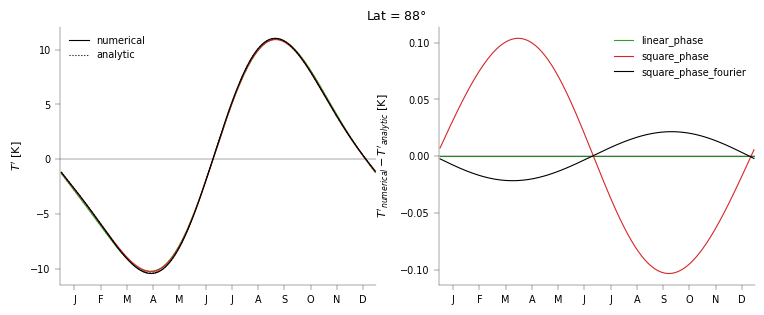

In [212]:
colors_use = {'linear': color_approx['linear'], 'linear_phase': default_colors[2], 'square': color_approx['square'],
              'square_phase': default_colors[3], 'square_phase_fourier': 'k', 'square_fourier': default_colors[4]}

fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for key in colors_use:
    if 'phase' not in key:
        continue
    ax[0].plot(ds.time, temp_anom_numerical[key][plot_lat_ind], color=colors_use[key], label='numerical' if 'square_phase_fourier' in key else None)
    ax[0].plot(ds.time, temp_anom_analytic[key][plot_lat_ind], linestyle=':', color=colors_use[key], label='analytic' if 'square_phase_fourier' in key else None)
    ax[1].plot(ds.time, temp_anom_numerical[key][plot_lat_ind] - temp_anom_analytic[key][plot_lat_ind], color=colors_use[key], label=key)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend()
ax[1].legend()
ax[0].set_xlim(-1, 360)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel("$T'$ [K]")
ax[1].set_ylabel("$T'_{numerical} - T'_{analytic}$ [K]")
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93)
plt.show()

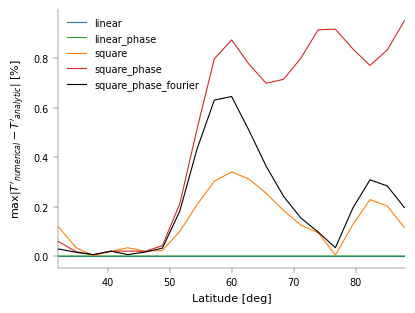

In [213]:
colors_use = {'linear': color_approx['linear'], 'linear_phase': default_colors[2], 'square': color_approx['square'],
              'square_phase': default_colors[3], 'square_phase_fourier': 'k'}
fig, ax = plt.subplots(1, 1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar))
for key in colors_use:
    ax.plot(ds.lat, 100*np.abs(temp_anom_analytic[key] - temp_anom_numerical[key]).max(axis=1)/temp_anom_numerical[key].max(axis=1),
            color=colors_use[key], label=key)
ax.set_xlim(ax_lims_lat)
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel("$\max{|T'_{numerical} - T'_{analytic}|}$ [%]")
ax.legend()
plt.show()

## Interpretation of Parameters in $\Gamma$ approximation
The different parameters in the approximation for $\Gamma$ can be interpreted in terms of an effective heat capacity and feedback parameter.

### $\lambda$ and $C$
If the surface energy budget is just $C\frac{dT}{dt} = -\lambda T$, then equation for $T$ is a sum over $n$ harmonics:

$T(t) = \sum_n T_n \cos(2n\pi ft - \phi_n)$

where $\tan \phi_n = 2n\pi f C / \lambda$, $T_n = \frac{F_n}{\lambda} \frac{1}{\sqrt{1 + \tan^2 \phi_n}}$ and $F_n$ is the amplitude of the insolation harmonic.

Restricting ourselves to two harmonics, the effect of $\lambda$ and $C$ on each is shown below:

In [214]:
def get_effective_heat_capacity_lambda_scale(heat_capacity, lambda_const, lambda_phase=0, lambda_sq=0, lambda_cos=0,
                                             lambda_sin=0, sw_amp1=None, sw_amp2=None, approx=False, n_days_year = 360, day_seconds=86400):
    # Get factors such that lambda_mod = lambda_scale * lambda and heat_capacity_mod = heat_capacity_scale * heat_capacity
    # Then with these modified factors, can use normal simple surface energy budget: C_mod * dT(t)/dt = F(t) - lambda_mod * T(t)
    f = 1/(n_days_year * day_seconds)
    if sw_amp1 is None:
        # If don't give insolation information, then return modification for parameters as seen by the 1st harmonic
        lambda_scale = 1
        heat_capacity_scale = 1 - lambda_phase / (2*np.pi*f*heat_capacity)
    else:
        # If have insolation information, return modification for parameters as seen by the 2nd harmonic
        x0 = 2*np.pi*f*heat_capacity / lambda_const
        sw_amp_eff = [sw_amp1, sw_amp2 - lambda_cos]

        sq_param = 0.5 * lambda_sq * sw_amp_eff[0]**2 / (lambda_const**2 * sw_amp_eff[1])/(1+x0**2)**2
        fourier_param = lambda_sin / sw_amp_eff[1]
        if approx:
            # Return linear taylor series solution
            lambda_scale = 1 + (3*x0**2+1)*sq_param + 2*x0*fourier_param
            heat_capacity_scale = 1 - x0**2 * sq_param - 0.5/x0 * fourier_param
        else:
            f_beta = 1 - (sq_param*(1+4*x0**2) + fourier_param*(2*x0+0.5/x0))/(1 + sq_param*(5*x0**2-1) + fourier_param*2*x0)
            lambda_scale = (1 + f_beta*4*x0**2) / (1 + sq_param*(x0**2-1)) / (1 + f_beta**2*4*x0**2)
            heat_capacity_scale = f_beta * lambda_scale
    return lambda_scale, heat_capacity_scale


def get_effective_lambda_interpretation(time, sw_amp1, sw_amp2, heat_capacity, lambda_const, lambda_phase=0, lambda_sq=0, lambda_cos=0, lambda_sin=0,
                                        approx=False, day_seconds=86400):
    f = 1/(time.size * day_seconds)
    sw_amp_eff = np.asarray([sw_amp1, sw_amp2 - lambda_cos])

    # Get effective parameters - allow different for each harmonic
    n_harmonics = 2
    lambda_mod = lambda_const * np.ones(n_harmonics)
    heat_capacity_mod = heat_capacity * np.ones(n_harmonics)

    # Phase - changes 1st harmonic only
    lambda_scale, heat_cap_scale = \
        get_effective_heat_capacity_lambda_scale(heat_capacity, lambda_const, lambda_phase, lambda_sq, lambda_cos, lambda_sin)
    lambda_mod[0] = lambda_mod[0] * lambda_scale
    heat_capacity_mod[0] = heat_capacity_mod[0] * heat_cap_scale
    # heat_capacity_mod[0] -= lambda_phase / (2*np.pi*f)

    lambda_scale, heat_cap_scale = \
        get_effective_heat_capacity_lambda_scale(heat_capacity, lambda_const, lambda_phase, lambda_sq, lambda_cos, lambda_sin,
                                                 sw_amp1, sw_amp2, approx)
    lambda_mod[1] = lambda_mod[1] * lambda_scale
    heat_capacity_mod[1] = heat_capacity_mod[1] * heat_cap_scale
    # x0 = 2*np.pi*f*heat_capacity / lambda_const
    # sq_param = 0.5 * lambda_sq * sw_amp_eff[0]**2 / (lambda_const**2 * sw_amp_eff[1])/(1+x0**2)**2
    # # sq_param = 0.5 * lambda_sq * sw_amp1**2 / (lambda_const**2 * sw_amp2)/(1+x0**2)**2
    # fourier_param = lambda_sin / sw_amp_eff[1]
    # # f_beta = (1 - fourier_param/(2*x0) - sq_param) / (1 + 2*x0*fourier_param + 4*x0**2*sq_param)
    # f_beta = 1 - (sq_param*(1+4*x0**2) + fourier_param*(2*x0-0.5/x0))/(1 + sq_param*(5*x0**2-1) + fourier_param*2*x0)
    # lambda_mod[1] = lambda_const * (1 + f_beta*4*x0**2) / (1 + sq_param*(x0**2-1)) / (1 + f_beta**2*4*x0**2)
    # heat_capacity_mod[1] = heat_capacity * f_beta * (1 + f_beta*4*x0**2) / (1 + sq_param*(x0**2-1)) / (1 + f_beta**2*4*x0**2)

    x = 2*np.pi*f*heat_capacity_mod * np.arange(1, n_harmonics+1)/lambda_mod
    phase_coef = np.arctan(x)
    amp_coef = sw_amp_eff / lambda_mod / np.sqrt(1 + x ** 2)
    harmonic1 = fourier.fourier_series(time, [0, amp_coef[0], 0], [phase_coef[0], 0])
    harmonic2 = fourier.fourier_series(time, [0, 0, amp_coef[1]], [0, phase_coef[1]])
    return harmonic1, harmonic2, harmonic1 + harmonic2

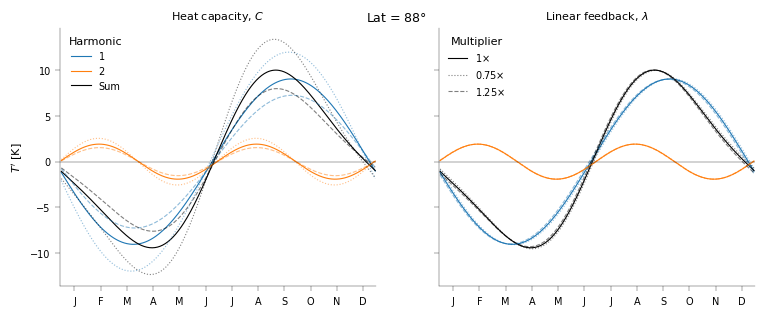

In [215]:
var_harmonic_schematic = get_effective_lambda_interpretation(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][plot_lat_ind, 1],
                                                             sw_amp_coefs['2_harmonic'][plot_lat_ind, 2], heat_capacity,
                                                             gamma_params['linear'][plot_lat_ind, 4])
multiplier = [1, 0.75, 1.25]
linestyle_multiplier = ['-', ':', '--']
color_schematic = [default_colors[0], default_colors[1], 'k']
labels_schematic = ['1', '2', 'Sum']
alpha_schematic = [1, 0.5, 0.5]
show_sanity_check = False
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
# Change heat capacity
ax[0].set_title('Heat capacity, $C$')
for j in range(len(multiplier)):
    var_use = get_effective_lambda_interpretation(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][plot_lat_ind, 1],
                                                  sw_amp_coefs['2_harmonic'][plot_lat_ind, 2], heat_capacity*multiplier[j],
                                                  gamma_params['linear'][plot_lat_ind, 4])
    for i in range(len(var_use)):
        ax[0].plot(ds.time, var_use[i], color=color_schematic[i], linestyle=linestyle_multiplier[j], label=labels_schematic[i] if j==0 else None,
                   alpha=alpha_schematic[j])
    if show_sanity_check and j == 0:
        # Should be zero
        ax[0].plot(ds.time, temp_anom_analytic['linear'][plot_lat_ind]-var_use[-1], color='r', linestyle='--')
        print(np.abs(temp_anom_analytic['linear'][plot_lat_ind]-var_use[-1]).max())

# Change lambda
ax[1].set_title('Linear feedback, $\lambda$')
for j in range(len(multiplier)):
    var_use = get_effective_lambda_interpretation(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][plot_lat_ind, 1],
                                                  sw_amp_coefs['2_harmonic'][plot_lat_ind, 2], heat_capacity,
                                                  gamma_params['linear'][plot_lat_ind, 4]*multiplier[j])
    for i in range(len(var_use)):
        ax[1].plot(ds.time, var_use[i], color=color_schematic[i], linestyle=linestyle_multiplier[j],
                   label=str(multiplier[j])+'$\\times$' if i==2 else None, alpha=alpha_schematic[j])




ax[0].legend(title='Harmonic')
ax[1].legend(title='Multiplier')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(ax_lims_time)
ax[0].set_ylabel("$T'$ [K]")
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93)
plt.show()

### Phase factor, $\lambda_{phase}$
A positive $\lambda_{phase}$ acts to reduce the heat capacity. This effect is only experienced by the 1st harmonic though, as is shown on the right plot where the 2nd harmonic is unchanged.

Thus, positive $\lambda_{phase}$ shifts both extrema earlier in the year and increases the amplitude.

The vertical markers indicate the latitudes used, larger marker means further north.

The effective heat capacity is given by $\frac{C_{eff}}{C} = 1 - \frac{\lambda}{2\pi f C}$.

1.7763568394002505e-15


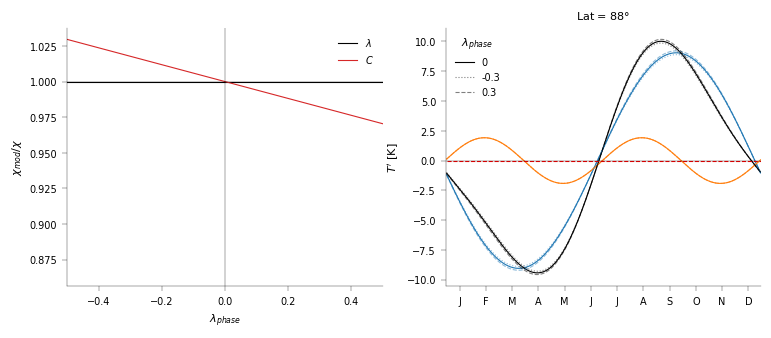

In [216]:
var_array = np.linspace(-0.5, 0.5, 101)
marker_size_lat = ((ds.lat-ds.lat.min()+5)/5)**2.5

fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar))
var_use = get_effective_heat_capacity_lambda_scale(heat_capacity, gamma_params['linear_phase'][plot_lat_ind, 4], lambda_phase=var_array)
ax[0].plot(var_array, np.ones_like(var_array), color='k', label='$\lambda$')
ax[0].plot(var_array, var_use[1], color=default_colors[3], label='$C$')
var_use = get_effective_heat_capacity_lambda_scale(heat_capacity, gamma_params['linear_phase'][:, 4],
                                                   lambda_phase=gamma_params['linear_phase'][:, 2])
ax[0].scatter(gamma_params['linear_phase'][:, 2], var_use[1], color=default_colors[3], s=marker_size_lat, marker='|')
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[0].axvline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(var_array.min(), var_array.max())
ax[0].set_xlabel('$\lambda_{phase}$')
ax[0].set_ylabel('$\chi_{mod}/\chi$')
ax[0].legend()


var = [0, -0.3, 0.3]
show_sanity_check = True
for j in range(len(multiplier)):
    var_use = get_effective_lambda_interpretation(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][plot_lat_ind, 1],
                                                  sw_amp_coefs['2_harmonic'][plot_lat_ind, 2], heat_capacity,
                                                  gamma_params['linear_phase'][plot_lat_ind, 4],
                                                  lambda_phase=var[j])
    for i in range(len(var_use)):
        ax[1].plot(ds.time, var_use[i], color=color_schematic[i], linestyle=linestyle_multiplier[j],
                   label=var[j] if i==2 else None, alpha=alpha_schematic[j])
if show_sanity_check:
    var_use = get_effective_lambda_interpretation(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][plot_lat_ind, 1],
                                                  sw_amp_coefs['2_harmonic'][plot_lat_ind, 2], heat_capacity,
                                                  gamma_params['linear_phase'][plot_lat_ind, 4], gamma_params['linear_phase'][plot_lat_ind, 2])
    # Should be zero
    ax[1].plot(ds.time, temp_anom_analytic['linear_phase'][plot_lat_ind]-var_use[-1], color='r', linestyle='--')
    print(np.abs(temp_anom_analytic['linear_phase'][plot_lat_ind]-var_use[-1]).max())
ax[1].set_title(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$")
ax[1].set_xticks(*month_ticks)
ax[1].set_xlim(ax_lims_time)
ax[1].set_ylabel("$T'$ [K]")
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].legend(title='$\lambda_{phase}$')

plt.show()

### Square Parameter, $\lambda_{sq}$
Positive $\lambda_{sq}$ acts to increase the effective $\lambda$ and decrease the effective heat capacity. This is only felt by the second harmonic though, with the first being unchanged.

The dotted lines on the left indicate the linear taylor series approximation which is more useful for interpretation:

$\frac{\lambda_{eff}}{\lambda} \approx 1 + (3x^2 + 1) \beta_{sq} + 2x\beta_{\Lambda}$

$\frac{C_{eff}}{C} \approx 1 - x^2 \beta_{sq} - \frac{1}{2x}\beta_{\Lambda}$

where $\beta_{sq} = \frac{F_1^2}{2\lambda^2 (F_2-\Lambda_{cos})(1+x^2)^2}\lambda_{sq}$; $\beta_{\Lambda} = \frac{1}{F_2-\Lambda_{cos}}\Lambda_{sin}$
and $x = 2\pi fC/\lambda$

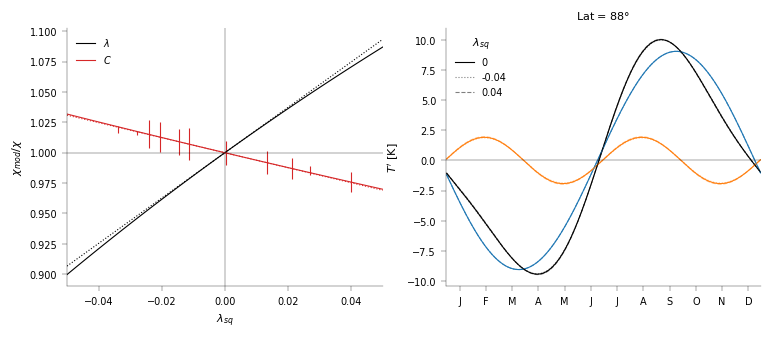

In [217]:
var_array = np.linspace(-0.05, 0.05, 101)

fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar))
var_use = get_effective_heat_capacity_lambda_scale(heat_capacity, gamma_params['square'][plot_lat_ind, 4], lambda_sq=var_array,
                                                   sw_amp1=sw_amp_coefs['2_harmonic'][plot_lat_ind, 1],
                                                   sw_amp2=sw_amp_coefs['2_harmonic'][plot_lat_ind, 2])
ax[0].plot(var_array, var_use[0], color='k', label='$\lambda$')
ax[0].plot(var_array, var_use[1], color=default_colors[3], label='$C$')
var_use = get_effective_heat_capacity_lambda_scale(heat_capacity, gamma_params['square'][plot_lat_ind, 4], lambda_sq=var_array,
                                                   sw_amp1=sw_amp_coefs['2_harmonic'][plot_lat_ind, 1],
                                                   sw_amp2=sw_amp_coefs['2_harmonic'][plot_lat_ind, 2], approx=True)
ax[0].plot(var_array, var_use[0], linestyle=':', color='k')
ax[0].plot(var_array, var_use[1], linestyle=':', color=default_colors[3])
var_use = get_effective_heat_capacity_lambda_scale(heat_capacity, gamma_params['square'][:, 4],
                                                   lambda_sq=gamma_params['square'][:, 3],
                                                   sw_amp1=sw_amp_coefs['2_harmonic'][plot_lat_ind, 1],
                                                   sw_amp2=sw_amp_coefs['2_harmonic'][plot_lat_ind, 2])
ax[0].scatter(gamma_params['square'][:, 3], var_use[1], color=default_colors[3], s=marker_size_lat, marker='|')
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[0].axvline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(var_array.min(), var_array.max())
ax[0].set_xlabel('$\lambda_{sq}$')
ax[0].set_ylabel('$\chi_{mod}/\chi$')
ax[0].legend()


var = [0, -0.04, 0.04]
show_sanity_check = False
show_approx = False
for j in range(len(multiplier)):
    var_use = get_effective_lambda_interpretation(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][plot_lat_ind, 1],
                                                  sw_amp_coefs['2_harmonic'][plot_lat_ind, 2], heat_capacity,
                                                  gamma_params['square'][plot_lat_ind, 4],
                                                  lambda_sq=var[j], approx=show_approx)
    for i in range(len(var_use)):
        ax[1].plot(ds.time, var_use[i], color=color_schematic[i], linestyle=linestyle_multiplier[j],
                   label=var[j] if i==2 else None, alpha=alpha_schematic[j])
if show_sanity_check:
    var_use = get_effective_lambda_interpretation(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][plot_lat_ind, 1],
                                                  sw_amp_coefs['2_harmonic'][plot_lat_ind, 2], heat_capacity,
                                                  gamma_params['square'][plot_lat_ind, 4], lambda_sq=gamma_params['square'][plot_lat_ind, 3],
                                                  approx=show_approx)
    # Should be zero
    ax[1].plot(ds.time, temp_anom_analytic['square'][plot_lat_ind]-var_use[-1], color='r', linestyle='--')
    print(np.abs(temp_anom_analytic['square'][plot_lat_ind]-var_use[-1]).max())
ax[1].set_title(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$")
ax[1].set_xticks(*month_ticks)
ax[1].set_xlim(ax_lims_time)
ax[1].set_ylabel("$T'$ [K]")
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].legend(title='$\lambda_{sq}$')

plt.show()

### Fourier Parameters, $\lambda_{sin}$
The $\Lambda_{sin}$ parameter acts to increase the $\lambda$ felt by the second harmonic, and does not change the heat capacity very much. It seems that the main effect of this is to increase the magnitude of the minima.

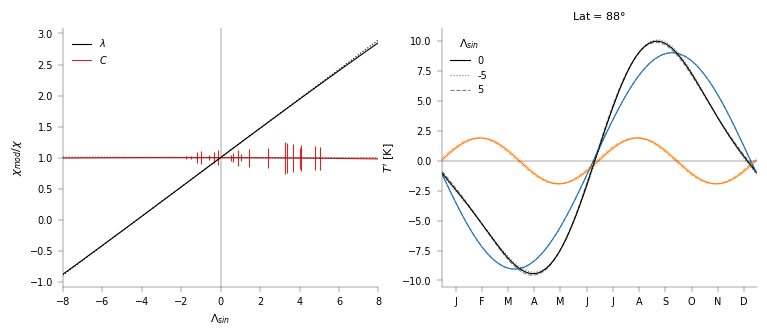

In [218]:
var_array = np.linspace(-8, 8, 101)

fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar))
var_use = get_effective_heat_capacity_lambda_scale(heat_capacity, gamma_params['linear_fourier'][plot_lat_ind, 4], lambda_sin=var_array,
                                                   sw_amp1=sw_amp_coefs['2_harmonic'][plot_lat_ind, 1],
                                                   sw_amp2=sw_amp_coefs['2_harmonic'][plot_lat_ind, 2])
ax[0].plot(var_array, var_use[0], color='k', label='$\lambda$')
ax[0].plot(var_array, var_use[1], color=default_colors[3], label='$C$')
var_use = get_effective_heat_capacity_lambda_scale(heat_capacity, gamma_params['linear_fourier'][plot_lat_ind, 4], lambda_sin=var_array,
                                                   sw_amp1=sw_amp_coefs['2_harmonic'][plot_lat_ind, 1],
                                                   sw_amp2=sw_amp_coefs['2_harmonic'][plot_lat_ind, 2], approx=True)
ax[0].plot(var_array, var_use[0], linestyle=':', color='k')
ax[0].plot(var_array, var_use[1], linestyle=':', color=default_colors[3])
var_use = get_effective_heat_capacity_lambda_scale(heat_capacity, gamma_params['linear_fourier'][:, 4],
                                                   lambda_sin=gamma_params['linear_fourier'][:, 1],
                                                   sw_amp1=sw_amp_coefs['2_harmonic'][plot_lat_ind, 1],
                                                   sw_amp2=sw_amp_coefs['2_harmonic'][plot_lat_ind, 2])
ax[0].scatter(gamma_params['linear_fourier'][:, 1], var_use[1], color=default_colors[3], s=marker_size_lat, marker='|')
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[0].axvline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(var_array.min(), var_array.max())
ax[0].set_xlabel('$\Lambda_{sin}$')
ax[0].set_ylabel('$\chi_{mod}/\chi$')
ax[0].legend()


var = [0, -5, 5]
show_approx = False
show_sanity_check = False
for j in range(len(multiplier)):
    var_use = get_effective_lambda_interpretation(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][plot_lat_ind, 1],
                                                  sw_amp_coefs['2_harmonic'][plot_lat_ind, 2], heat_capacity,
                                                  gamma_params['linear_fourier'][plot_lat_ind, 4],
                                                  lambda_sin=var[j], approx=show_approx)
    for i in range(len(var_use)):
        ax[1].plot(ds.time, var_use[i], color=color_schematic[i], linestyle=linestyle_multiplier[j],
                   label=var[j] if i==2 else None, alpha=alpha_schematic[j])
if show_sanity_check:
    # This is for including cos and sin terms, but still useful
    var_use = get_effective_lambda_interpretation(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][plot_lat_ind, 1],
                                                  sw_amp_coefs['2_harmonic'][plot_lat_ind, 2], heat_capacity,
                                                  gamma_params['linear_fourier'][plot_lat_ind, 4],
                                                  lambda_cos=gamma_params['linear_fourier'][plot_lat_ind, 0],
                                                  lambda_sin=gamma_params['linear_fourier'][plot_lat_ind, 1],
                                                  approx=show_approx)
    # Should be zero
    ax[1].plot(ds.time, temp_anom_analytic['linear_fourier'][plot_lat_ind]-var_use[-1], color='r', linestyle='--')
    print(np.abs(temp_anom_analytic['linear_fourier'][plot_lat_ind]-var_use[-1]).max())
ax[1].set_title(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$")
ax[1].set_xticks(*month_ticks)
ax[1].set_xlim(ax_lims_time)
ax[1].set_ylabel("$T'$ [K]")
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].legend(title='$\Lambda_{sin}$')

plt.show()

### Fourier Parameters, $\lambda_{cos}$
The $\lambda_{cos}$ parameter reduces the value of $F_2$, so the second harmonic experiences reduced (or more negative) insolation. A positive value reduces the amplitude of the second harmonic in the northern hemisphere.

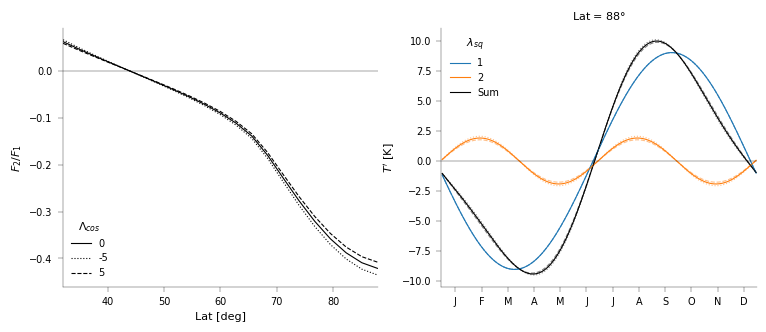

In [219]:
# var_array = np.linspace(-5, 5, 101)
var = [0, -5, 5]
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar))
var_use = get_effective_heat_capacity_lambda_scale(heat_capacity, gamma_params['linear_fourier'][plot_lat_ind, 4], lambda_cos=var_array,
                                                   sw_amp1=sw_amp_coefs['2_harmonic'][plot_lat_ind, 1],
                                                   sw_amp2=sw_amp_coefs['2_harmonic'][plot_lat_ind, 2])
for j in range(len(multiplier)):
    ax[0].plot(ds.lat, sw_amp_coefs['2_harmonic'][:, 2]/(sw_amp_coefs['2_harmonic'][:, 1]-var[j]), linestyle=linestyle_multiplier[j],
               color='k', label=var[j])
ax[0].set_xlabel('Lat [deg]')
ax[0].set_ylabel('$F_2/F_1$')
ax[0].legend(title='$\Lambda_{cos}$')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(ax_lims_lat)


for j in range(len(multiplier)):
    var_use = get_effective_lambda_interpretation(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][plot_lat_ind, 1],
                                                  sw_amp_coefs['2_harmonic'][plot_lat_ind, 2], heat_capacity,
                                                  gamma_params['linear_fourier'][plot_lat_ind, 4],
                                                  lambda_cos=var[j])
    for i in range(len(var_use)):
        ax[1].plot(ds.time, var_use[i], color=color_schematic[i], linestyle=linestyle_multiplier[j],
                   label=labels_schematic[i] if j==0 else None, alpha=alpha_schematic[j])
ax[1].set_title(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$")
ax[1].set_xticks(*month_ticks)
ax[1].set_xlim(ax_lims_time)
ax[1].set_ylabel("$T'$ [K]")
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].legend(title='$\lambda_{sq}$')

plt.show()

In [220]:
def get_shift_t_analytic_temp(time, sw_amp1, sw_amp2, heat_capacity, lambda_const, lambda_phase=0, lambda_sq=0, lambda_cos=0, lambda_sin=0,
                              approx=False, day_seconds=86400):
    # Returns solution of form a_1cos(2 pi f t') + b_1sin(2 pi f t') + a_2cos(4 pi f t') + b_2sin(4 pi f t')
    # where t' = t - t_{max1} where t_{max1} is time of 1st harmonic extrema in case where lambda_phase=0, lambda_sq=0, lambda_cos=0, lambda_sin=0.
    f = 1/(time.size * day_seconds)
    sw_amp_eff = np.asarray([sw_amp1, sw_amp2 - lambda_cos])

    # Get effective parameters - allow different for each harmonic
    n_harmonics = 2
    eta = np.ones(n_harmonics)      # lambda_mod = eta * lambda
    heat_cap_scale = np.ones(n_harmonics)   # heat_capacity_mod = heat_cap_scale * heat_capacity

    # 1st harmonic
    eta[0], heat_cap_scale[0] = \
        get_effective_heat_capacity_lambda_scale(heat_capacity, lambda_const, lambda_phase, lambda_sq, lambda_cos, lambda_sin)

    # 2nd harmonic
    eta[1], heat_cap_scale[1] = \
        get_effective_heat_capacity_lambda_scale(heat_capacity, lambda_const, lambda_phase, lambda_sq, lambda_cos, lambda_sin,
                                                 sw_amp1, sw_amp2, approx)
    mu = heat_cap_scale / eta       # mu = (heat_capacity_mod / lambda_mod) / (heat_capacity/lambda) = heat_cap_scale / eta

    x = 2*np.pi*f*heat_capacity/lambda_const
    a_1 = sw_amp_eff[0]/lambda_const/eta[0] * (1 + mu[0]*x**2)/np.sqrt((1+x**2)*(1+mu[0]**2*x**2)**2)
    b_1 = -sw_amp_eff[0]/lambda_const/eta[0] * x * (1-mu[0])/np.sqrt((1+x**2)*(1+mu[0]**2*x**2)**2)
    a_2 = sw_amp_eff[0]/lambda_const/eta[1] * (sw_amp_eff[1]/sw_amp_eff[0]) * (1-x**2+4*mu[1]*x**2)/((1+x**2)*(1+4*mu[1]**2*x**2))
    b_2 = sw_amp_eff[0]/lambda_const/eta[1] * (sw_amp_eff[1]/sw_amp_eff[0]) * (2*mu[1]*x*(1-x**2) - 2*x)/((1+x**2)*(1+4*mu[1]**2*x**2))
    time_shift = time * day_seconds - np.arctan(x)/(2*np.pi*f)      # in seconds
    temp_analytic = a_1 * np.cos(2*np.pi*f*time_shift) + b_1 * np.sin(2*np.pi*f * time_shift) + a_2 * np.cos(4*np.pi*f * time_shift) + b_2 * np.sin(4*np.pi*f * time_shift)
    return temp_analytic, a_1, b_1, a_2, b_2

In [221]:
# Sanity check
key = 'square_phase_fourier'        # expect combination of square and phase to give slight error due to neglecting combined phase-square effects
                                    # all else should be 0
show_approx = False                 # Check linear taylor series version
var = []
var2 = []
for i in range(n_lat):
    var_use = get_effective_lambda_interpretation(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][i, 1],
                                                  sw_amp_coefs['2_harmonic'][i, 2], heat_capacity,
                                                  gamma_params[key][i, 4], lambda_phase=gamma_params[key][i, 2],
                                                  lambda_sq=gamma_params[key][i, 3],
                                                  lambda_cos=gamma_params[key][i, 0],
                                                  lambda_sin=gamma_params[key][i, 1], approx=show_approx)
    # Check that shifting around maxima of 1st harmonic correct
    var_use2 = get_shift_t_analytic_temp(ds.time.to_numpy(), sw_amp_coefs['2_harmonic'][i, 1],
                                         sw_amp_coefs['2_harmonic'][i, 2], heat_capacity,
                                         gamma_params[key][i, 4], lambda_phase=gamma_params[key][i, 2],
                                         lambda_sq=gamma_params[key][i, 3],
                                         lambda_cos=gamma_params[key][i, 0],
                                         lambda_sin=gamma_params[key][i, 1])
    # Should be zero
    var += [np.round(np.abs(temp_anom_analytic[key][i]-var_use[-1]).max(), 6)]
    var2 += [np.round(np.abs(var_use2[0]-var_use[-1]).max(), 6)]
print(var)
print(var2)

[0.017937, 0.010509, 0.002594, 0.01, 0.009743, 0.003861, 0.004138, 0.016092, 0.03056, 0.039977, 0.039347, 0.030286, 0.020146, 0.011589, 0.006159, 0.003257, 0.000973, 0.005078, 0.007508, 0.006495, 0.004346]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
